<a href="https://colab.research.google.com/github/BaaaaCode/Kaggle/blob/main/%5BKaggle_W12%5D_Insurance_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/sample_submission.csv
/kaggle/input/insurance/train.csv
/kaggle/input/insurance/test.csv


# **Regression with an Insurance Dataset**
https://www.kaggle.com/competitions/playground-series-s4e12/overview

# **환경설정**

In [ ]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math

# sklearn & scippy 라이브러리
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.signal import find_peaks
from scipy.stats import skew

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [ ]:
# 경고문 무시
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 로그 메시지 출력 레벨 설정
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

In [ ]:
# 데이터 불러오기
train_data = pd.read_csv("../input/insurance/train.csv")
test_data = pd.read_csv("../input/insurance/test.csv")

# 데이터 형태 확인
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (1200000, 21)
Test shape: (800000, 20)


# **데이터 확인**
1. 데이터 구조
    1. Train Dataset: 1,200,000 rows * 20 columns1.
    2. Test Dataset: 800,000 rows * 19 columns
    3. Target Feature: Premium Amount
*
   
2. 요구 작업
    1. 결측치 처리: Age, Annual Income, Marital Status, Number of Dependents, Occupation, Health Score, Previous Claims, Vehicle Age, Credit Score, Insurance Duration, Customer Feedback
    2. 데이터 타입에 따른 columns 분리
       1. object 데이터 전처리


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [ ]:
train_data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


# **데이터 전처리**

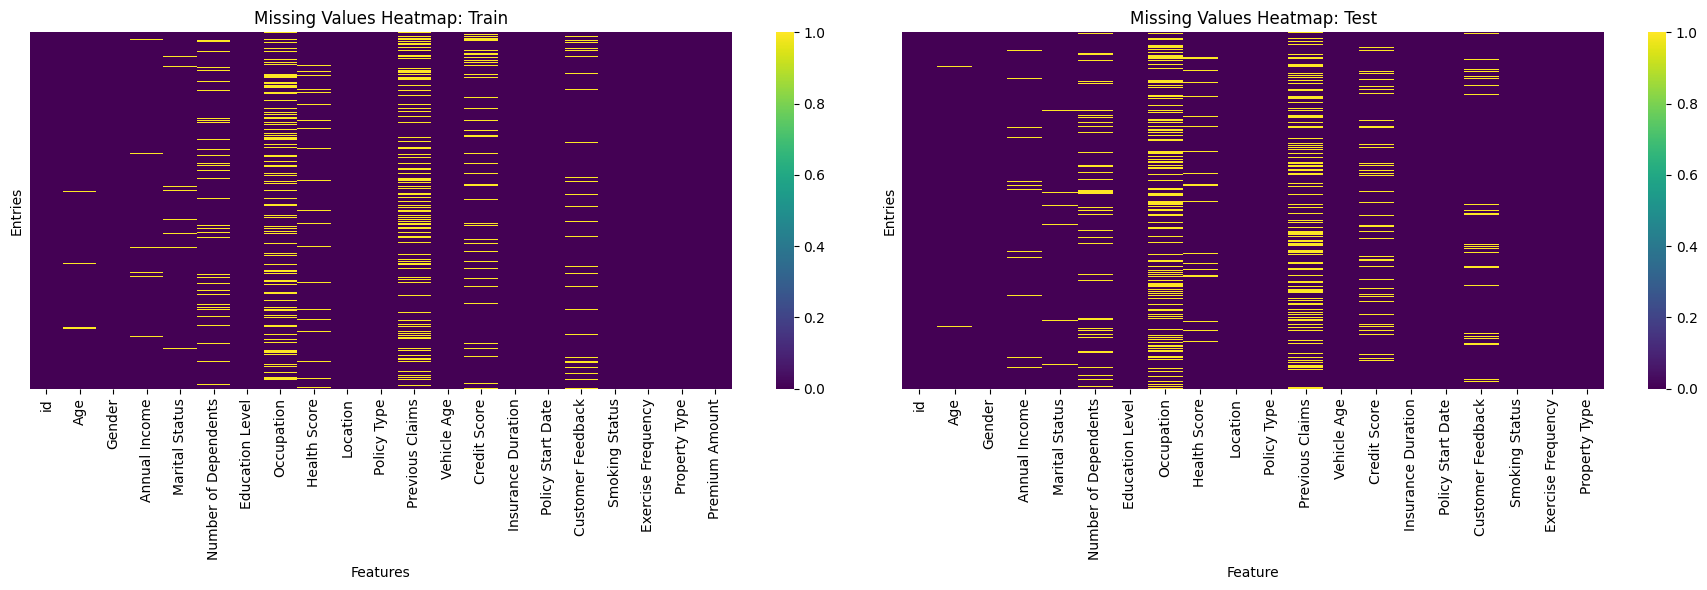

In [ ]:
# 결측치 추출
missing_train = train_data.isnull()
missing_test = test_data.isnull()

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(18,6))

sns.heatmap(missing_train, cmap='viridis', cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title("Missing Values Heatmap: Train")
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Entries')

sns.heatmap(missing_test, cmap='viridis', cbar=True, yticklabels=False, ax=axes[1])
axes[1].set_title("Missing Values Heatmap: Test")
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Entries')

plt.tight_layout()
plt.show()

1. 주요 결측치: Number of Dependents, Occupation, Previous Claims, Credit Score, Customer Feedback
2. Train & Test 결측치 분포: 서로 유사함
3. 전처리 주의 요구 변수: Previous Claims, Credit Score

,Missing Values,Percentage(%),Data Type
Age,18705,1.558750,float64
Annual Income,44949,3.745750,float64
Marital Status,18529,1.544083,object
Number of Dependents,109672,9.139333,float64
Occupation,358075,29.839583,object
Health Score,74076,6.173000,float64
Previous Claims,364029,30.335750,float64
Vehicle Age,6,0.000500,float64
Credit Score,137882,11.490167,float64
Insurance Duration,1,0.000083,float64


,Missing Values,Percentage(%),Data Type
Age,12489,1.561125,float64
Annual Income,29860,3.732500,float64
Marital Status,12336,1.542000,object
Number of Dependents,73130,9.141250,float64
Occupation,239125,29.890625,object
Health Score,49449,6.181125,float64
Previous Claims,242802,30.350250,float64
Vehicle Age,3,0.000375,float64
Credit Score,91451,11.431375,float64
Insurance Duration,2,0.000250,float64


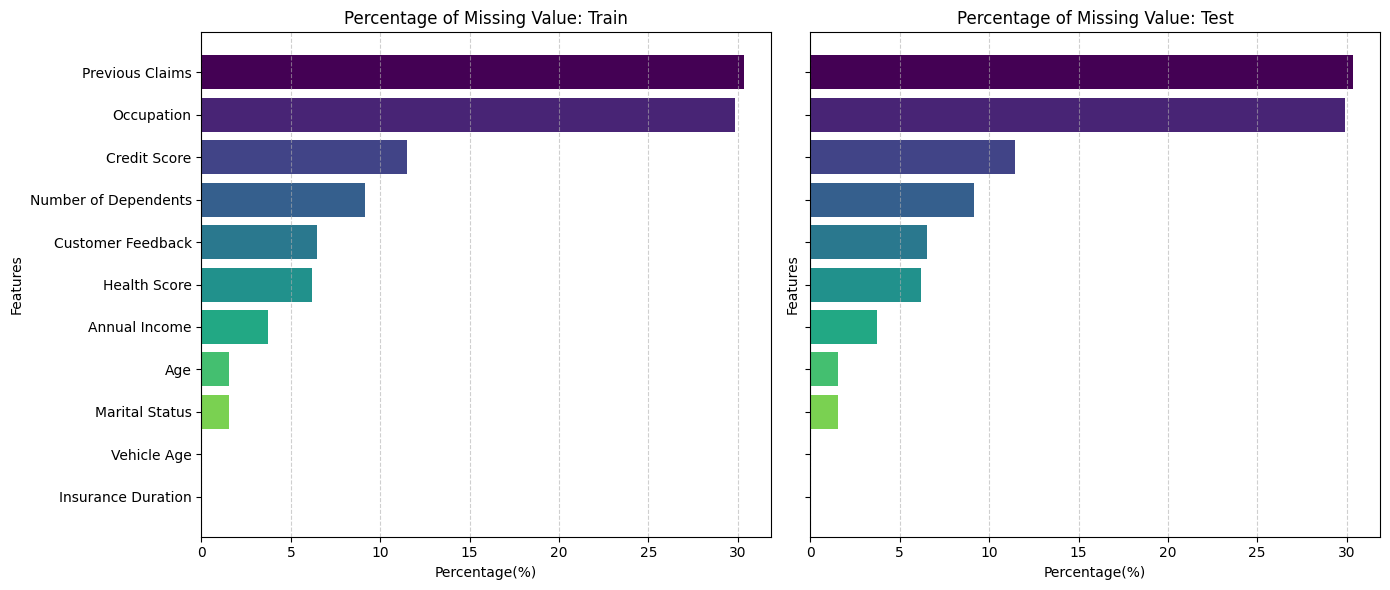

In [ ]:
# 결측치 비율 파악
def missing_values_table(df):
    missing_count = df.isnull().sum()
    missing_percentage = 100*missing_count/len(df)
    data_types = df.dtypes
    return pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage(%)': missing_percentage,
        'Data Type': data_types
    })

train_missing_table = missing_values_table(train_data)
test_missing_table = missing_values_table(test_data)

display(train_missing_table[train_missing_table['Missing Values'] > 0])
display(test_missing_table[test_missing_table['Missing Values'] > 0])

# 결측치 존재 컬럼 추출
train_missing = train_missing_table[train_missing_table['Missing Values'] > 0].sort_values(by='Percentage(%)', ascending=False)
test_missing = test_missing_table[test_missing_table['Missing Values'] > 0].sort_values(by='Percentage(%)', ascending=False)

# barplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

train_colors = cm.get_cmap('viridis', len(train_missing))(range(len(train_missing)))
axes[0].barh(train_missing.index, train_missing['Percentage(%)'], color=train_colors)
axes[0].set_title("Percentage of Missing Value: Train")
axes[0].set_xlabel("Percentage(%)")
axes[0].set_ylabel('Features')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)
axes[0].invert_yaxis()

test_colors = cm.get_cmap('viridis', len(test_missing))(range(len(test_missing)))
axes[1].barh(test_missing.index, test_missing['Percentage(%)'], color=test_colors)
axes[1].set_title("Percentage of Missing Value: Test")
axes[1].set_xlabel("Percentage(%)")
axes[1].set_ylabel('Features')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

1. 결측치 처리
   1. 숫자형 데이터: 중간값 또는 평균값 대입 (Previous Claims, Occuption 등)
   2. 범주형 데이터: NaN 대입 (Credit Score, Number of Dependnts 등)

In [ ]:
# 결측치 처리(numerical > median)
numeric_col = train_data.select_dtypes(include=['number']).columns

for col in numeric_col:
    if col in test_data.columns:
        train_data[col].fillna(-1, inplace=True)
        test_data[col].fillna(-1, inplace=True)

# for col in numeric_col:
#     if col in test_data.columns:
#         median_value = train_data[col].median()
#         train_data[col].fillna(median_value, inplace=True)
#         test_data[col].fillna(median_value, inplace=True

In [ ]:
# 결측치 대입 값 산출
features_with_missing = train_missing_table[train_missing_table['Missing Values'] > 0].index.tolist()

def analyze_nan_with_target_filtered(df, target_column, features):
    missing_analysis = {}

    for col in features:
        missing_mask = df[col].isnull()
        non_missing_mask = ~missing_mask

        stats = {
            'Missing Count': missing_mask.sum(),
            'Non-Missing Count': non_missing_mask.sum(),
            'Mean (Missing)': df.loc[missing_mask, target_column].mean(),
            'Mean (Non-Missing)': df.loc[non_missing_mask, target_column].mean(),
            'Median (Missing)': df.loc[missing_mask, target_column].median(),
            'Median (Non-Missing)': df.loc[non_missing_mask, target_column].median(),
            'Std Dev (Missing)': df.loc[missing_mask, target_column].std(),
            'Std Dev (Non-Missing)': df.loc[non_missing_mask, target_column].std()
        }
        missing_analysis[col] = stats
    return pd.DataFrame(missing_analysis).T

missing_vs_premium_filtered = analyze_nan_with_target_filtered(train_data, "Premium Amount", features_with_missing)

missing_vs_premium_filtered

,Missing Count,Non-Missing Count,Mean (Missing),Mean (Non-Missing),Median (Missing),Median (Non-Missing),Std Dev (Missing),Std Dev (Non-Missing)
Age,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Annual Income,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Marital Status,18529.0,1181471.0,1217.871067,1100.736161,1001.0,871.0,904.286237,864.246334
Number of Dependents,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Occupation,358075.0,841925.0,1093.320969,1106.467773,861.0,876.0,859.637058,867.239987
Health Score,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Previous Claims,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Vehicle Age,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Credit Score,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859
Insurance Duration,0.0,1200000.0,NaN,1102.544822,NaN,872.0,NaN,864.998859


In [ ]:
# 결측치 처리(object > NaN)
object_col = train_data.select_dtypes(include=['object']).columns

for col in object_col:
    if col in test_data.columns:
        train_data[col].fillna('Unknown', inplace=True)
        test_data[col].fillna('Unknown', inplace=True)

In [ ]:
# 결측치 처리 확인
print(f"{train_data.isnull().sum()}\n----------\n{test_data.isnull().sum()}")

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64
----------
id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedb

# **데이터 시각화**

## **Premium Amount**

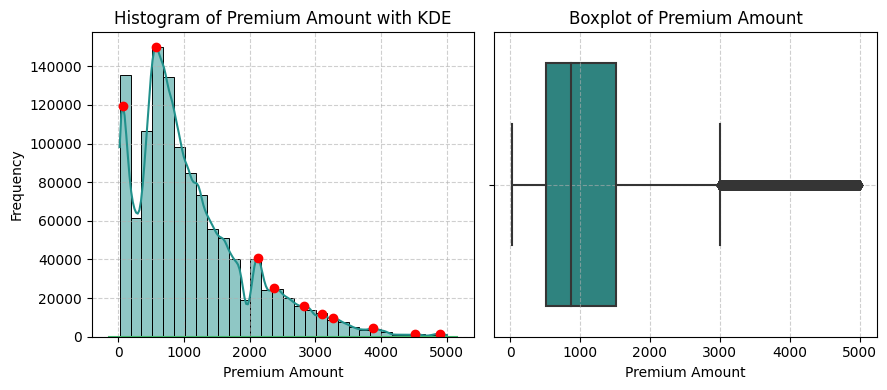

In [ ]:
# Premium Amount
target_column = (set(train_data.columns) - set(test_data.columns)).pop()
# cmap 설정
viridis_cmap = cm.get_cmap('viridis')

# premium amount 정보 산출
def visualize_premium_amount_with_peaks(data, feature='Premium Amount'):
    # premium amount hist(with kde)
    plt.figure(figsize=(9,4))
    plt.subplot(1, 2, 1)
    ax = sns.histplot(data[feature], bins=30, kde=True, color=viridis_cmap(0.5))
    plt.title(f"Histogram of {feature} with KDE")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

    # kde 극댓값(봉우리, peak)
    kde = sns.kdeplot(data[feature], ax=ax, color=viridis_cmap(0.7)).lines[0].get_data()
    kde_x, kde_y = kde[0], kde[1]
    peaks, _ = find_peaks(kde_y)

    # kde 극댓갑 표현
    for peak_idx in peaks:
        plt.plot(kde_x[peak_idx], kde_y[peak_idx], "ro")

    # premium amount boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature], color=viridis_cmap(0.5))
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


visualize_premium_amount_with_peaks(train_data, feature='Premium Amount')

1. 분포 특성
    1. 형태: 오른쪽으로 치우친 분포를 보이고 있음.(높은 보험료의 사례 적음)
    2. 특잇값: 가장 높은 극댓값은 1000 주변에 나타나며, 현재 데이터 세트에서 가장 많이 나타나는 보험료 값임을 알 수 있음

2. 이상치
    1. 분포: 상당수의 보험료 값이 사분위 범위 내에 존재(낮은 보험료 다수)
    2. 특이사항: 사분위 범위 외 존재하는 이상치의 추가 분석 필요

## **Numerical Data**

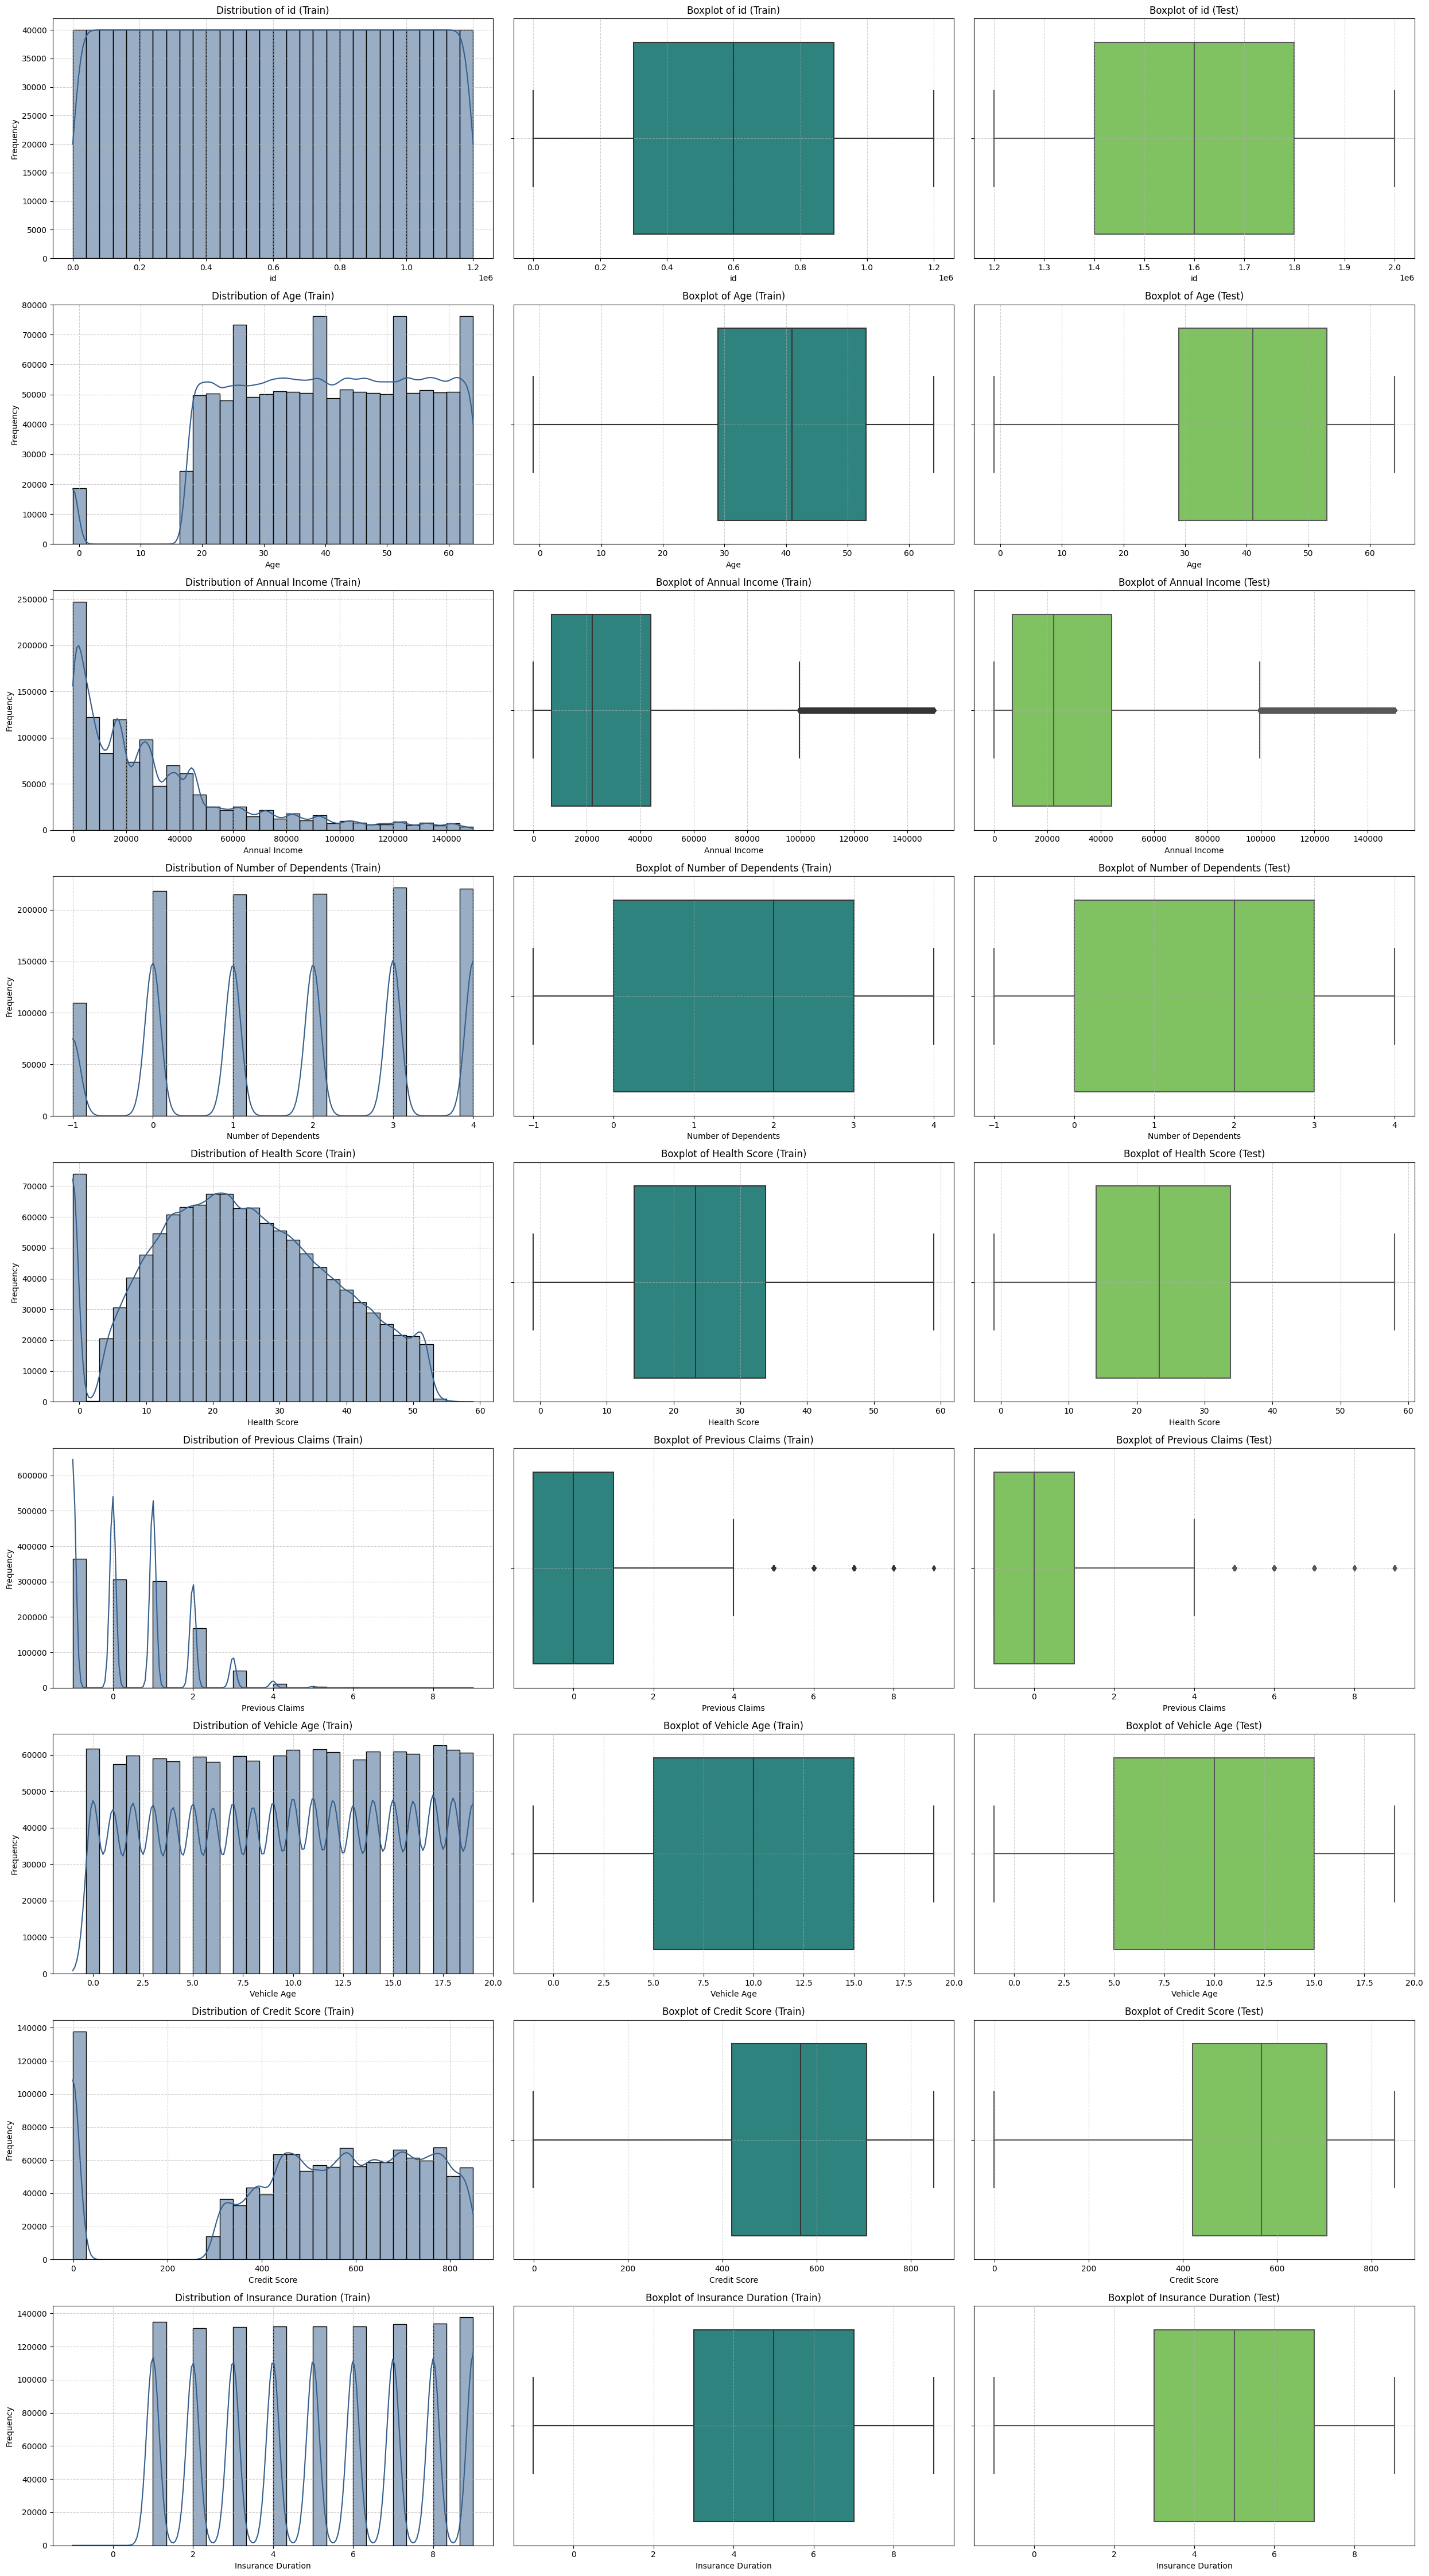

In [ ]:
# 수치형 데이터 분석
# 수치형 데이터 추출
columns_to_analyze = train_data.select_dtypes(include=['number']).columns.drop('Premium Amount')

# cmap 설정
viridis_cmap = cm.get_cmap('viridis')
viridis_colors = [viridis_cmap(0.3), viridis_cmap(0.5), viridis_cmap(0.8)]

fig, axes = plt.subplots(len(columns_to_analyze), 3, figsize=(25, len(columns_to_analyze)*5))

for i, column in enumerate(columns_to_analyze):
    # hist of numerical
    sns.histplot(train_data[column], bins=30, kde=True, color=viridis_colors[0], ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {column} (Train)")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(visible=True, linestyle='--', alpha=0.6)

    # boxplot of numerical(Train)
    sns.boxplot(x=train_data[column], color=viridis_colors[1], ax=axes[i,1])
    axes[i, 1].set_title(f"Boxplot of {column} (Train)")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].grid(visible=True, linestyle='--', alpha=0.6)

    # boxplot of numerical(Test)
    sns.boxplot(x=test_data[column], color=viridis_colors[2], ax=axes[i,2])
    axes[i, 2].set_title(f"Boxplot of {column} (Test)")
    axes[i, 2].set_xlabel(column)
    axes[i, 2].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

1. 각 변수 별 특징
    1. **Age**: 대체로 고른 분포를 보이나, 특정 나이대에 몰려 있는 특징을 가짐
    2. **Annual** Income: 특정 소득(10,000)에 대체로 몰려 있음
    3. **Number of Dependents**: 고른 분포를 보이나, 결측치가 다소 많이 있음을 고려할 필요가 있음.
    4. **Health Score**: 약간 왼쪽으로 치우친 정규분포의 양상을 보이고 있음. 다만, Health Score=0인 값이 많이 존재하므로, 예측 시 해당 변수를 고려해야 함.
    5. **Vechicle Age**: 고른 분포를 보임
    6. **Credit Score**: 특정 점수(600)를 기점으로 점수가 분포해 있음. 다만, Credit Score=0인 값이 많이 존재하므로, 예측 시 이를 고려해야 함
    7. **Insurance Duration**: 가입 기간의 분포는 고른 분포를 보이고 있음. 각 변수에 대해 영향력이 낮을 것으로 예상됨

2. Train:Test
    1. Train과 Test set의 boxplot을 살펴보면 각 feature별 분포가 유사함.

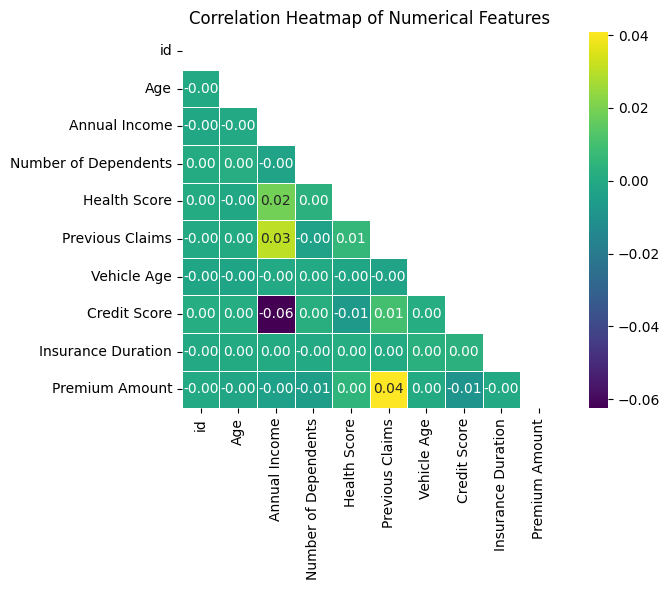

In [ ]:
# 상관관계 도출
# 숫자형 데이터 추출
numeric_data = train_data.select_dtypes(include=['number'])

# 상관관계 도출
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(8, 6))

# heatmap 출력
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', cbar=True,
            square=True, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
           linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

1. 특징
    1. 대부분의 변수가 목적변수와 상관관계가 약한 것으로 나타남 > 비선형 관계 적용 필요 (Tree-base-Algorithm)

2. 주요 관계
    1. Credit Score-Annual Income (-0.06)
    2. Premium Amount-Previous Claims (0.04)
    3. Previous Claims-Annual Income (0.03)
    4. Health Score-Annual Income (0.02)


## **Categorical Data**

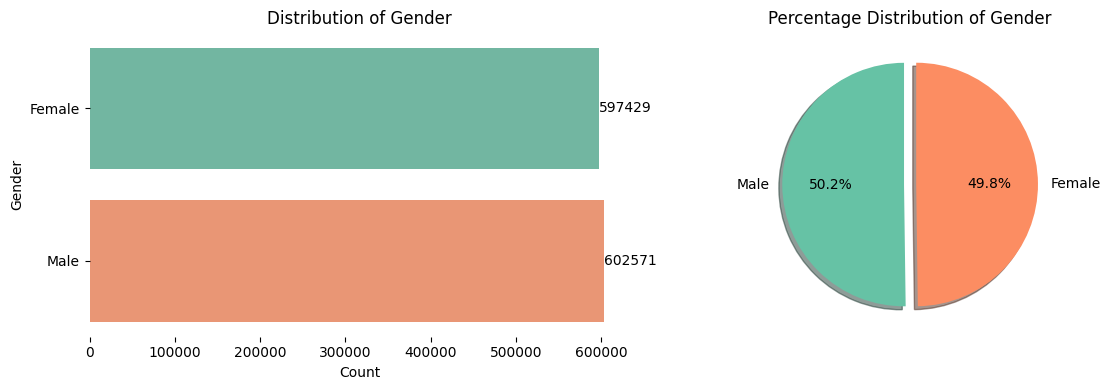

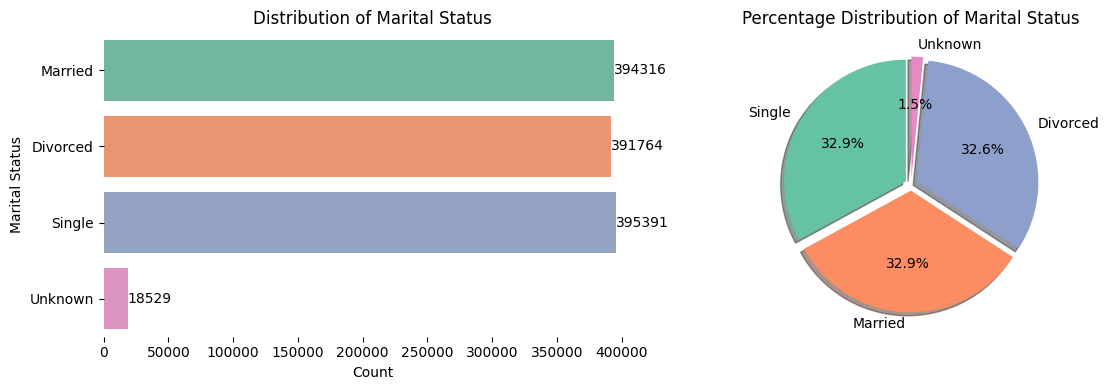

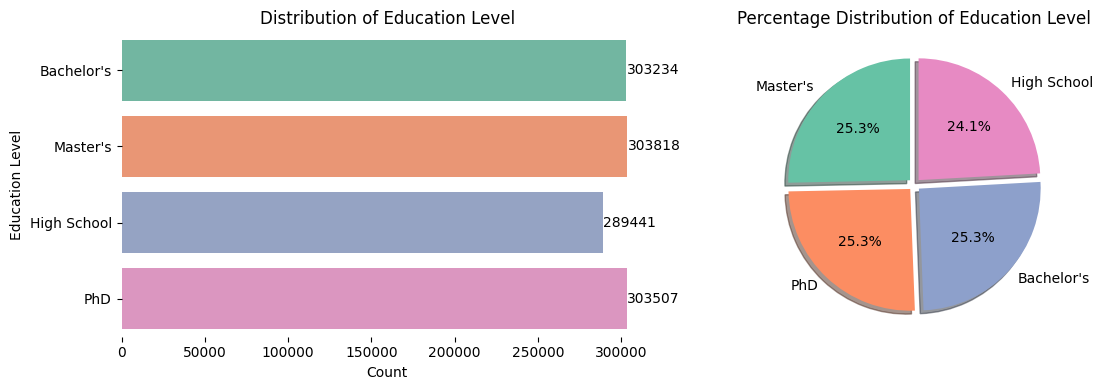

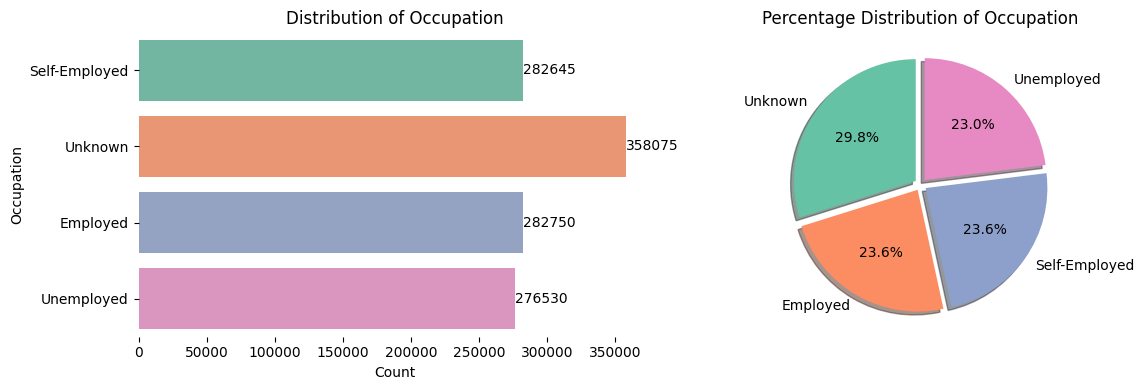

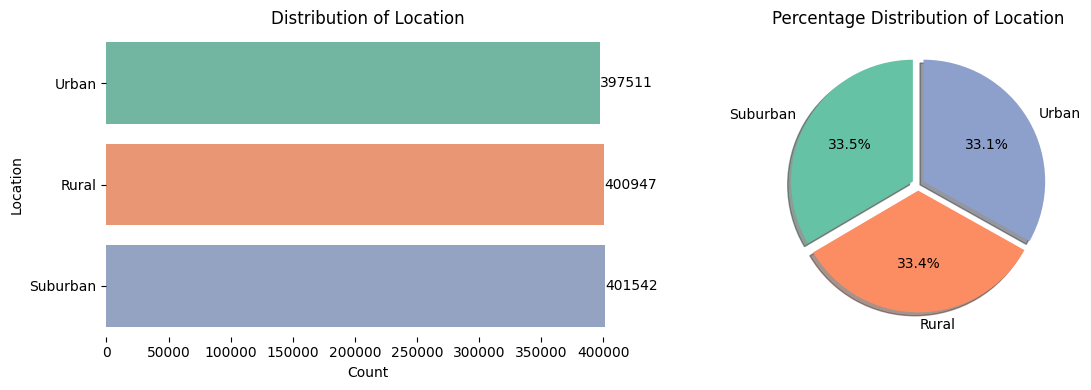

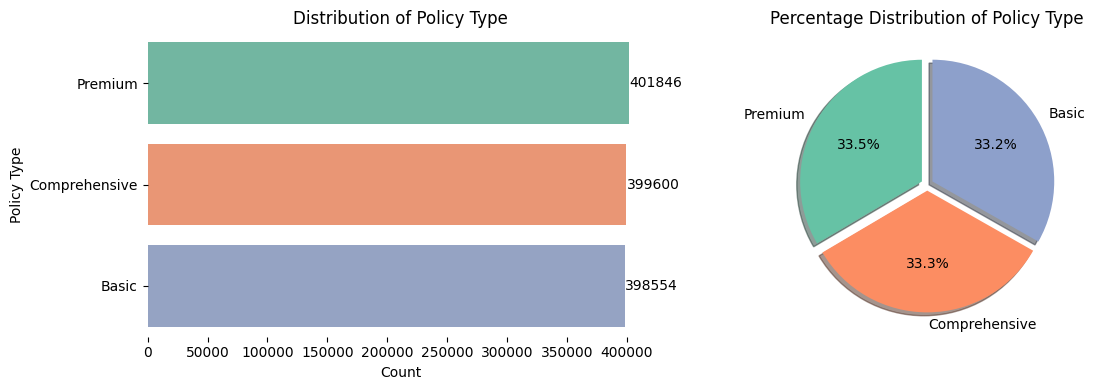

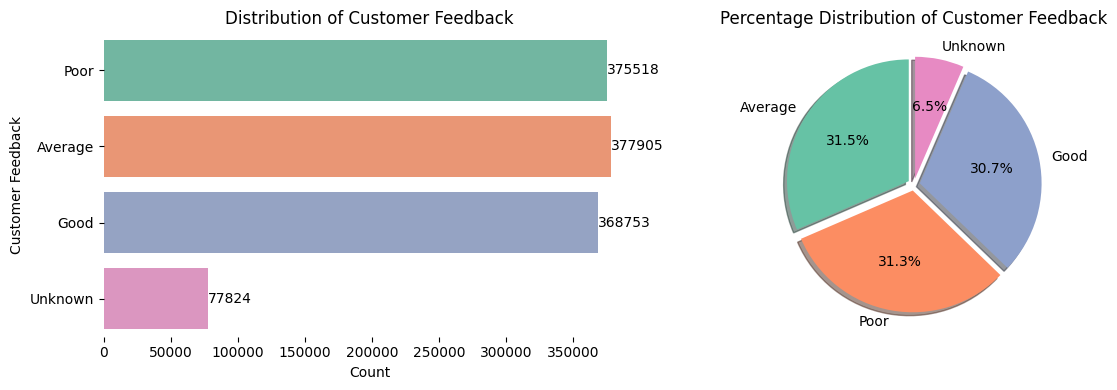

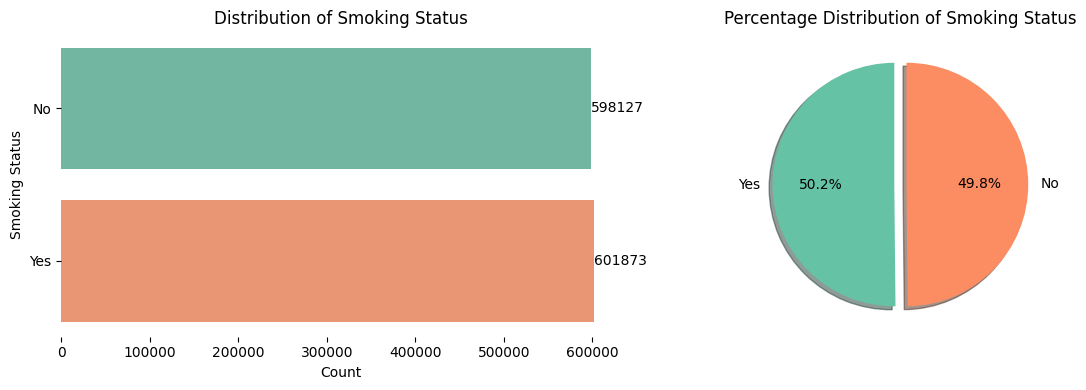

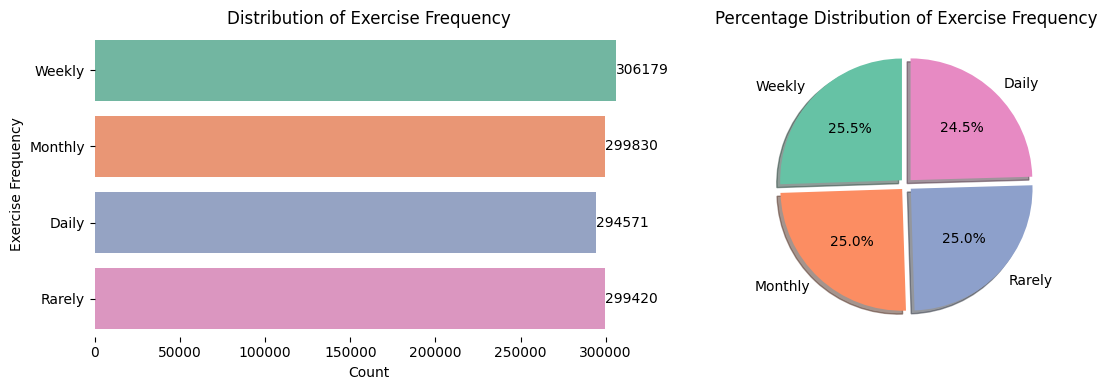

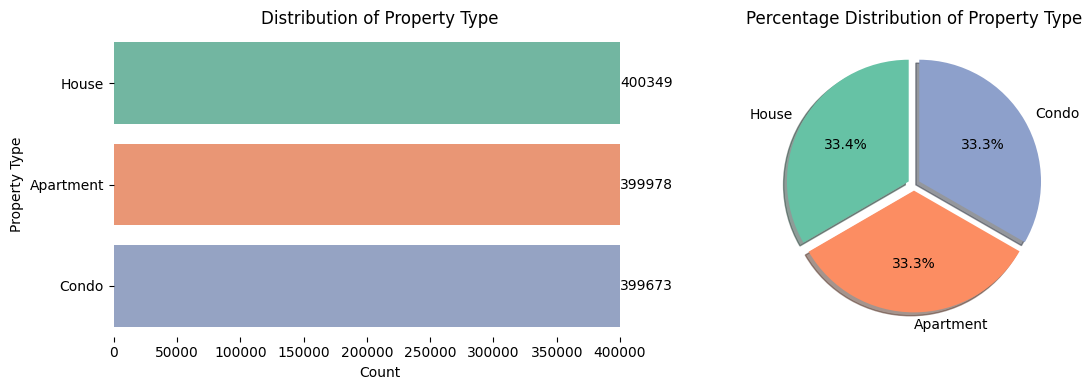

In [ ]:
# 범주형 데이터 분석
def plot_categorical_distribution(data, column_name):
    plt.figure(figsize=(12, 4))

    # barplot of categorical
    plt.subplot(1, 2, 1)
    sns.countplot(y=column_name, data=data, palette='Set2')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel('Count')
    plt.ylabel(column_name)

    ax = plt.gca()

    for p in ax.patches:
        count = int(p.get_width())
        ax.annotate(f"{count}",
                    (p.get_width()+0.1, p.get_y()+p.get_height()/2),
                    ha='left', va='center', fontsize=10, color='black')
        sns.despine(left=True, bottom=True)

    # piechart for percentage distribution
    plt.subplot(1, 2, 2)
    data[column_name].value_counts().plot.pie(
            autopct='%1.1f%%', colors=sns.color_palette('Set2', data[column_name].nunique()),
            startangle=90, explode=[0.05]*data[column_name].nunique(),shadow=True
        )
    plt.title(f"Percentage Distribution of {column_name}")
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

for column in categorical_columns:
    plot_categorical_distribution(train_data, column)

1. 각 변수 별 특징
    1. **Gender**: 범주 간 균등한 분포를 보임
    2. **Marital Status**: 범주 간 균등한 분포를 보임. 결측치가 존재하나 큰 비중을 차지하지 않음
    3. **Education Level**: 범주 간 균등한 분포를 보임
    4. **Occuptaion**: 결측치가 많이 존재함. 그 외 다른 범주 간 분포는 균등함.
    5. **Location**: 범주 간 균등한 분포를 보임
    6. **Policy Type**: 범주 간 균등한 분포를 보임. 각 범주별 각종 변수간 영향력이 클 것으로 예상
    7. **Customer Feedback**: 범주 간 균등한 분포를 보임
    8. **Smoking Status**: 범주 간 균등한 분포를 보임
    9. **Exercise Frquency**: 범주 간 균등한 분포를 보임
    10. **Property Type**: 범주 간 균등한 분포를 보임


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


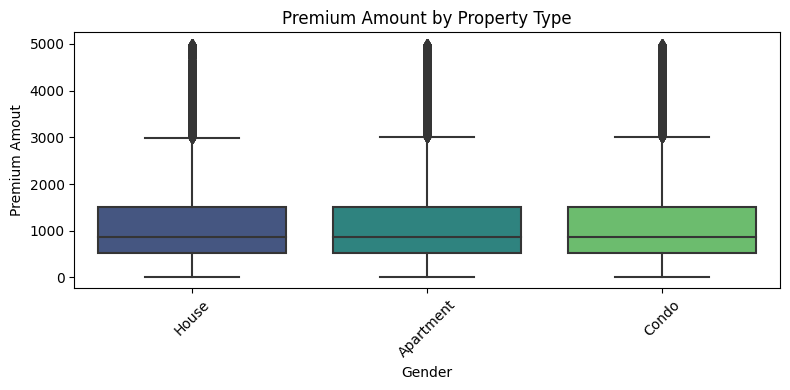


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


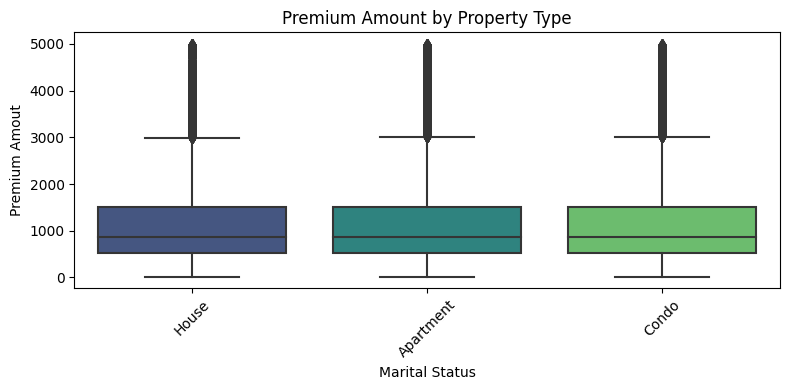


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


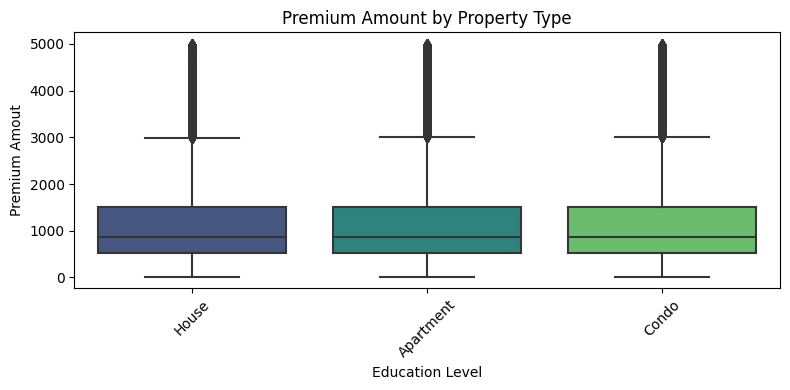


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


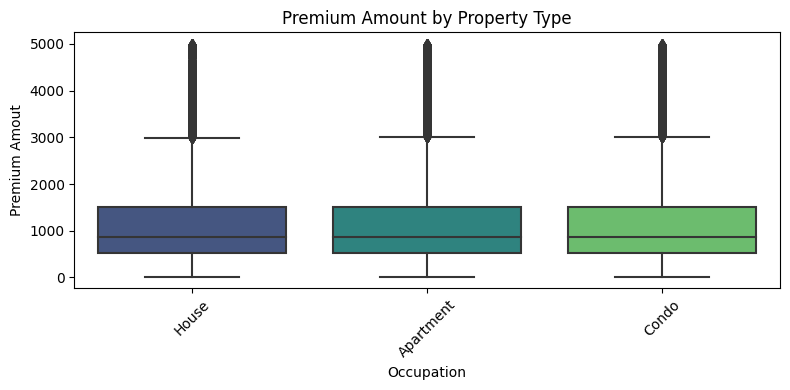


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


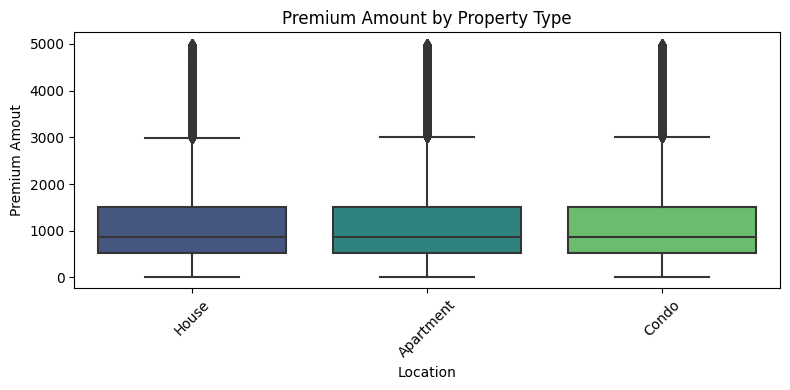


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


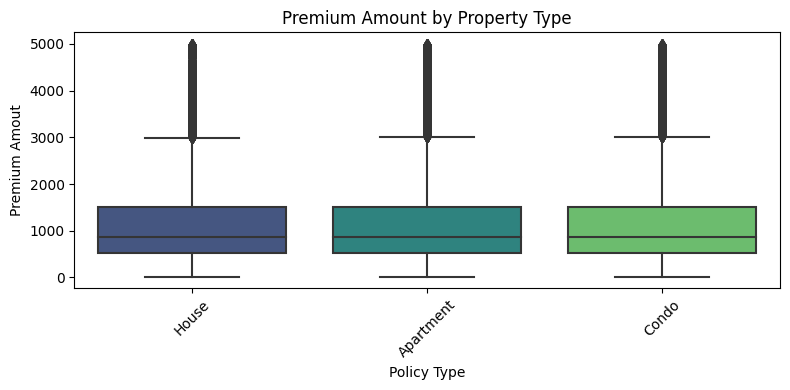


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


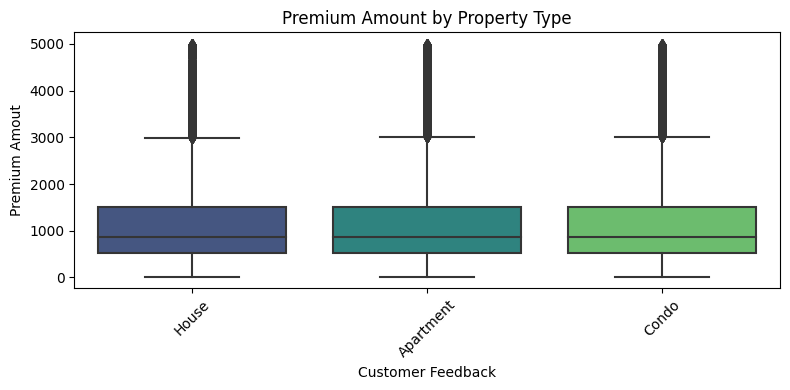


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


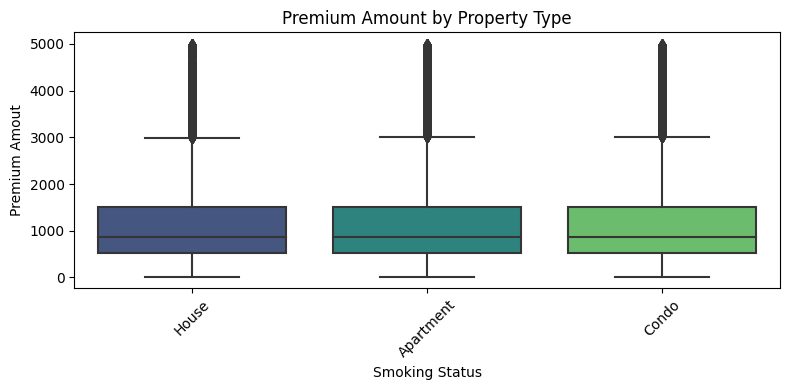


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


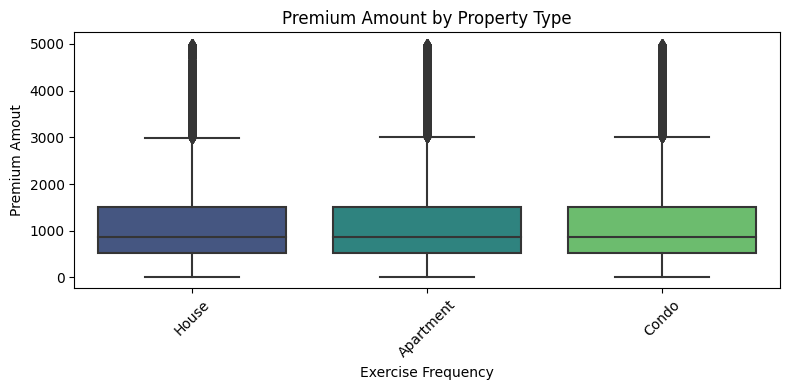


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


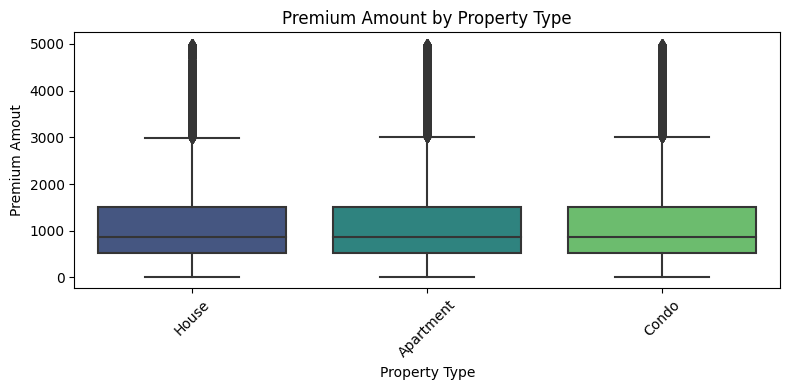

In [ ]:
# 번주형 데이터 분석 2
# 분석 데이터 추출
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
    'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type'
]

for colum in categorical_columns:
    # Premium Amout에 대한 categorical_column 변화
    stats = train_data.groupby(column)['Premium Amount'].agg(['mean', 'median', 'count'])
    print(f"\nSummary Statistics for Premium Amount by {column}:")
    print(stats)

    # Premium Amout에 대한 categorical_column 변화(boxplot)
    plt.figure(figsize=(8,4))
    sns.boxplot(data=train_data, x=column, y='Premium Amount', palette='viridis')
    plt.title(f"Premium Amount by {column}")
    plt.xlabel(colum)
    plt.ylabel('Premium Amout')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# **데이터 전처리**

In [ ]:
# 데이터 변환(object > datetime: epoch time )
datetime_columns = train_data.select_dtypes(include=['object']).columns

for col in datetime_columns:
    try:
        train_data[col] = pd.to_datetime(train_data[col], errors='raise')
        test_data[col] = pd.to_datetime(test_data[col], errors='raise')

        train_data[col] = train_data[col].astype(np.int64)/10**9
        test_data[col] = test_data[col].astype(np.int64)/10**9

        print(f"Converted '{col}' to epoch time.")
    except Exception as e:
        print(f"Skipping column '{col}' due to: {e}")
# 적용 결과: Policy Start Data 만 변환

Skipping column 'Gender' due to: Unknown datetime string format, unable to parse: Female, at position 0
Skipping column 'Marital Status' due to: Unknown datetime string format, unable to parse: Married, at position 0
Skipping column 'Education Level' due to: Unknown datetime string format, unable to parse: Bachelor's, at position 0
Skipping column 'Occupation' due to: Unknown datetime string format, unable to parse: Self-Employed, at position 0
Skipping column 'Location' due to: Unknown datetime string format, unable to parse: Urban, at position 0
Skipping column 'Policy Type' due to: Unknown datetime string format, unable to parse: Premium, at position 0
Converted 'Policy Start Date' to epoch time.
Skipping column 'Customer Feedback' due to: Unknown datetime string format, unable to parse: Poor, at position 0
Skipping column 'Smoking Status' due to: Unknown datetime string format, unable to parse: No, at position 0
Skipping column 'Exercise Frequency' due to: Unknown datetime string f

In [ ]:
# 데이터 변환 결과 확인
column_name = 'Policy Start Date'

# Train_data
print(f"Sample data for {column_name}': \n", train_data[column_name].head())
print(f"Data type of '{column_name}' in train_data: {train_data[column_name].dtype}")
# Test_data
print(f"Sample data for {column_name}': \n", test_data[column_name].head())
print(f"Data type of '{column_name}' in train_data: {test_data[column_name].dtype}")

Sample data for Policy Start Date': 
 0    1.703345e+09
1    1.686583e+09
2    1.696087e+09
3    1.718206e+09
4    1.638372e+09
Name: Policy Start Date, dtype: float64
Data type of 'Policy Start Date' in train_data: float64
Sample data for Policy Start Date': 
 0    1.685892e+09
1    1.713799e+09
2    1.680708e+09
3    1.698247e+09
4    1.637940e+09
Name: Policy Start Date, dtype: float64
Data type of 'Policy Start Date' in train_data: float64


In [ ]:
# 문자열 데이터 Encoding 정보 탐색
def identify_non_numerical_feature(data, dataset_name):
    non_numerical_feature = data.select_dtypes(include=['object'])
    print(f"Non-Numerical Features and Unique Values un {dataset_name} dataset:")
    for column in non_numerical_feature.columns:
        unique_values = non_numerical_feature[column].unique()
        print(f"\n{column}: {unique_values}")

# Train&Test set
identify_non_numerical_feature(train_data, "Training")
identify_non_numerical_feature(test_data, "Test")

Non-Numerical Features and Unique Values un Training dataset:

Gender: ['Female' 'Male']

Marital Status: ['Married' 'Divorced' 'Single' 'Unknown']

Education Level: ["Bachelor's" "Master's" 'High School' 'PhD']

Occupation: ['Self-Employed' 'Unknown' 'Employed' 'Unemployed']

Location: ['Urban' 'Rural' 'Suburban']

Policy Type: ['Premium' 'Comprehensive' 'Basic']

Customer Feedback: ['Poor' 'Average' 'Good' 'Unknown']

Smoking Status: ['No' 'Yes']

Exercise Frequency: ['Weekly' 'Monthly' 'Daily' 'Rarely']

Property Type: ['House' 'Apartment' 'Condo']
Non-Numerical Features and Unique Values un Test dataset:

Gender: ['Female' 'Male']

Marital Status: ['Unknown' 'Married' 'Divorced' 'Single']

Education Level: ["Bachelor's" "Master's" 'PhD' 'High School']

Occupation: ['Self-Employed' 'Unemployed' 'Unknown' 'Employed']

Location: ['Rural' 'Suburban' 'Urban']

Policy Type: ['Basic' 'Premium' 'Comprehensive']

Customer Feedback: ['Poor' 'Good' 'Average' 'Unknown']

Smoking Status: ['Yes'

In [ ]:
# 문자형 Encoding feature
binary_features = ['Gender', 'Smoking Status']
ordinal_features = {
    'Exercise Frequency': ['Rarely', 'Monthly', 'Weekly', 'Daily']
}
nominal_features = ['Marital Status', 'Education Level', 'Occupation',
                    'Location', 'Policy Type', 'Customer Feedback', 'Property Type']

le = LabelEncoder()

# binary_features encoding
for feature in binary_features:
    train_data[feature] = le.fit_transform(train_data[feature])
    test_data[feature] = le.transform(test_data[feature])

# ordinal_feature encoding
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order])
    train_data[feature] = oe.fit_transform(train_data[[feature]]).flatten()
    test_data[feature] = oe.transform(test_data[[feature]]).flatten()

# nominal_feature one-hot encoding
train_data = pd.get_dummies(train_data, columns=nominal_features, drop_first=True)
test_data = pd.get_dummies(test_data, columns=nominal_features, drop_first=True)

In [ ]:
# 데이터 유형 확인
train_data_types = pd.DataFrame({
    'Column Name': train_data.columns,
    'Train Data Type': train_data.dtypes
})

test_data_types = pd.DataFrame({
    'Column Name': test_data.columns,
    'Test Data Type': test_data.dtypes
})

data_types_comparison = pd.merge(
    train_data_types,
    test_data_types,
    on='Column Name',
    how='outer'
)

display(data_types_comparison)

,Column Name,Train Data Type,Test Data Type
0,id,int64,int64
1,Age,float64,float64
2,Gender,int64,int64
3,Annual Income,float64,float64
4,Number of Dependents,float64,float64
5,Health Score,float64,float64
6,Previous Claims,float64,float64
7,Vehicle Age,float64,float64
8,Credit Score,float64,float64
9,Insurance Duration,float64,float64


In [ ]:
# 숫자형 데이터 추출
numerical_columns = train_data.select_dtypes(include=['float64']).columns
numerical_columns = numerical_columns[numerical_columns != target_column]

# 정규화
scaler = StandardScaler()
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

In [ ]:
# log 변환 대상 추출
continuous_columns_train = ['Annual Income', 'Premium Amount']
continuous_columns_test = ['Annual Income']

# 변환 대상 왜도 계산
train_skewness = train_data[continuous_columns_train].apply(skew)
test_skewness = test_data[continuous_columns_test].apply(skew)

# 변환 대상 왜도 출력
print("Skewness for Training Dataset:\n")
display(train_skewness)
print("Skewness for TestDataset:\n")
display(test_skewness)

Skewness for Training Dataset:



Annual Income     1.490474
Premium Amount    1.240914
dtype: float64

Skewness for TestDataset:



Annual Income    1.484572
dtype: float64

In [ ]:
train_data['Annual Income'] = np.log1p(train_data['Annual Income'])
test_data['Annual Income'] = np.log1p(test_data['Annual Income'])

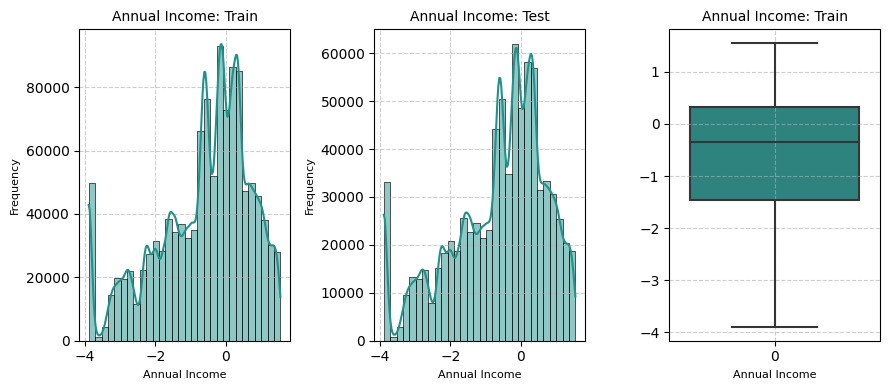

In [ ]:
# log1p 변환 결과 (Annual Income)
plt.figure(figsize=(9, 4))

plt.subplot(1,3,1)
sns.histplot(train_data['Annual Income'], bins=30, kde=True, color=viridis_cmap(0.5))
plt.title(f"Annual Income: Train", fontsize=10)
plt.xlabel('Annual Income', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,3,2)
sns.histplot(test_data['Annual Income'], bins=30, kde=True, color=viridis_cmap(0.5))
plt.title(f"Annual Income: Test", fontsize=10)
plt.xlabel('Annual Income', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,3,3)
sns.boxplot(train_data['Annual Income'], color=viridis_cmap(0.5))
plt.title(f"Annual Income: Train", fontsize=10)
plt.xlabel('Annual Income', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
numeric_data = train_data.select_dtypes(include=['number'])

numeric_data['Log_Transformed_Premium'] = np.log1p(train_data[target_column])

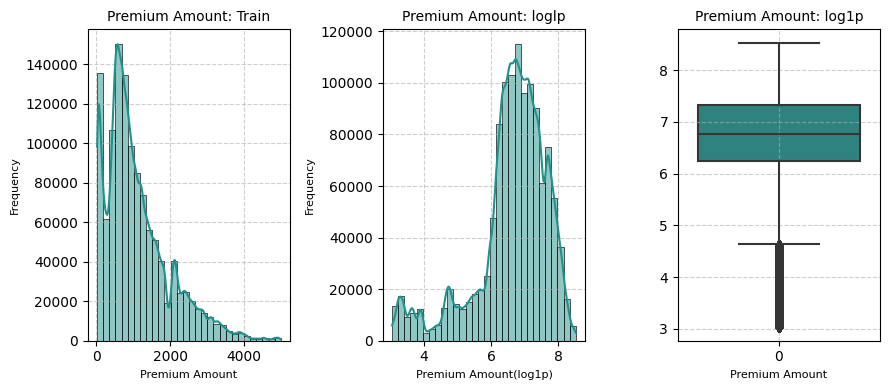

In [ ]:
# log1p 변환 결과 (Premiumn Amount)
plt.figure(figsize=(9, 4))

plt.subplot(1,3,1)
sns.histplot(train_data['Premium Amount'], bins=30, kde=True, color=viridis_cmap(0.5))
plt.title(f"Premium Amount: Train", fontsize=10)
plt.xlabel('Premium Amount', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,3,2)
sns.histplot(numeric_data['Log_Transformed_Premium'], bins=30, kde=True, color=viridis_cmap(0.5))
plt.title(f"Premium Amount: loglp", fontsize=10)
plt.xlabel('Premium Amount(log1p)', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,3,3)
sns.boxplot(numeric_data['Log_Transformed_Premium'], color=viridis_cmap(0.5))
plt.title(f"Premium Amount: log1p", fontsize=10)
plt.xlabel('Premium Amount', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

1. 왜도 특징
   1. Annual Income: (skew)1.522 > 중간 정도의 양의 왜도, 오른쪽 꼬리를 달고 있으며, 상당수의 작은 소득 값과 적은 수의 소득 값을 나타냄
   2. Premium Amount: (skew) 1.240 > 양의 왜도, 대부분의 보험료 값이 낮은 범위에 존재하고 높은 보험료의 값은 적음을 의미

2. 로그 변환
    1. 적용 로그: log1p(상용로그)  
    2. 해당 과정을 통해 왜도를 줄이고, 넓게 퍼진 큰 값들의 범위를 줄임. 극단적 이상치의 영향을 최소화할 수 있음

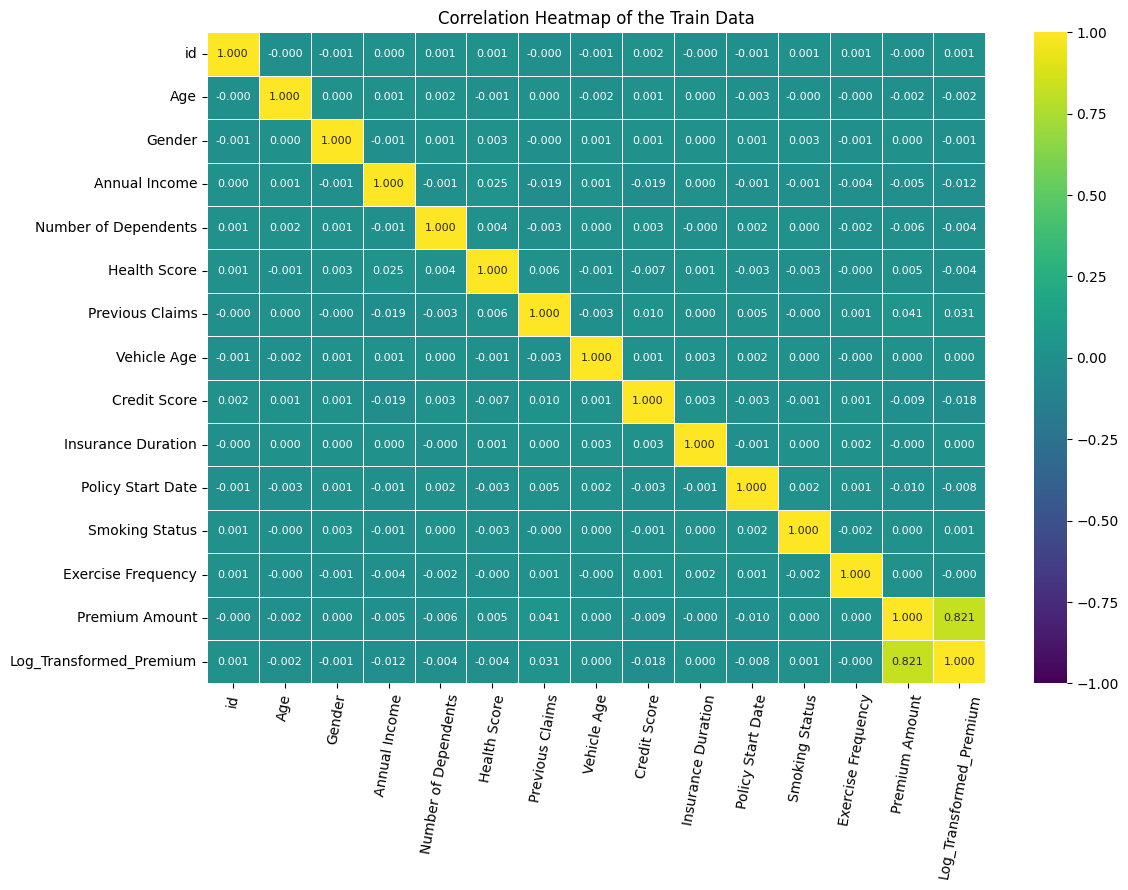

In [ ]:
train_corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(
    train_corr_matrix, annot=True, cmap='viridis',
    vmax=1, vmin=-1, annot_kws={'size': 8}, fmt='.3f', linewidths=0.5

)

plt.xticks(rotation=80)

plt.title('Correlation Heatmap of the Train Data')

plt.tight_layout()
plt.show()

1. Premium Amount vs Log_Transformed_Premium
   1. 기존 Premium Amount에 비해 Log_Transformed_Premium는 다른 feature와 관계가 약함. 이는 기존 변수의 범위를 줄여 극단적인 값의 영향을 줄여주기 때문임.

In [ ]:
# 데이터 분리
X_train = train_data.drop([target_column], axis=1) # Feature
y_train = train_data[target_column] # Target Variable

y_train_log = np.log1p(y_train) # Target Variable(log1p)

In [ ]:
# 명칭 변경 및 통일
X_train.columns = X_train.columns.str.replace(' ', '_', regex=True)
test_data.columns = test_data.columns.str.replace(' ', '_', regex=True)

print("Updated Feature Names in X_train:")
print(X_train.columns)

print("\nUpdated Feature Names in test_data:")
print(test_data.columns)

Updated Feature Names in X_train:
Index(['id', 'Age', 'Gender', 'Annual_Income', 'Number_of_Dependents',
       'Health_Score', 'Previous_Claims', 'Vehicle_Age', 'Credit_Score',
       'Insurance_Duration', 'Policy_Start_Date', 'Smoking_Status',
       'Exercise_Frequency', 'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Education_Level_High_School',
       'Education_Level_Master's', 'Education_Level_PhD',
       'Occupation_Self-Employed', 'Occupation_Unemployed',
       'Occupation_Unknown', 'Location_Suburban', 'Location_Urban',
       'Policy_Type_Comprehensive', 'Policy_Type_Premium',
       'Customer_Feedback_Good', 'Customer_Feedback_Poor',
       'Customer_Feedback_Unknown', 'Property_Type_Condo',
       'Property_Type_House'],
      dtype='object')

Updated Feature Names in test_data:
Index(['id', 'Age', 'Gender', 'Annual_Income', 'Number_of_Dependents',
       'Health_Score', 'Previous_Claims', 'Vehicle_Age', 'Credit_Score',
       'Insur

# **모델링**

In [ ]:
# 하이퍼 파라미터 최적화를 위한 목적함수
def objective(trial):
    param = {
         "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "device": "gpu",  # 일반 환경에서는 cpu 변경
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "verbose": -1  # Suppress warnings and messages
    }

    # Train/Test 데이터 분리
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_log, test_size=0.2, random_state=42)

    model = lgb.LGBMRegressor(**param)
    model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=30, verbose=False), log_evaluation(10)]
    )

    y_pred = model.predict(X_val)
    rmsle= mean_squared_log_error(y_val, y_pred)**0.5

    return rmsle

In [ ]:
# Optuna 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print("Best parameters:", study.best_params)
print("Best RMSLE:", study.best_value)

[I 2024-12-29 09:00:04,990] A new study created in memory with name: no-name-30004a9a-6639-4020-bf75-a89200ffd557


[10]	valid_0's rmse: 1.08544
[20]	valid_0's rmse: 1.07584
[30]	valid_0's rmse: 1.06643
[40]	valid_0's rmse: 1.06223
[50]	valid_0's rmse: 1.05718
[60]	valid_0's rmse: 1.05444
[70]	valid_0's rmse: 1.0532
[80]	valid_0's rmse: 1.05093
[90]	valid_0's rmse: 1.04983
[100]	valid_0's rmse: 1.04927
[110]	valid_0's rmse: 1.04883
[120]	valid_0's rmse: 1.04842
[130]	valid_0's rmse: 1.04823


[I 2024-12-29 09:00:20,517] Trial 0 finished with value: 0.15858961596501164 and parameters: {'learning_rate': 0.04514373750561482, 'n_estimators': 137, 'max_depth': 8, 'num_leaves': 179, 'min_child_samples': 83, 'subsample': 0.8688861191893226, 'colsample_bytree': 0.6054676411199733, 'reg_alpha': 0.0010641876837256317, 'reg_lambda': 4.854011853351337}. Best is trial 0 with value: 0.15858961596501164.


[10]	valid_0's rmse: 1.08507
[20]	valid_0's rmse: 1.07487
[30]	valid_0's rmse: 1.06533
[40]	valid_0's rmse: 1.06054
[50]	valid_0's rmse: 1.0566
[60]	valid_0's rmse: 1.05374
[70]	valid_0's rmse: 1.05215
[80]	valid_0's rmse: 1.05047
[90]	valid_0's rmse: 1.04958
[100]	valid_0's rmse: 1.04878
[110]	valid_0's rmse: 1.04816
[120]	valid_0's rmse: 1.04783
[130]	valid_0's rmse: 1.04755
[140]	valid_0's rmse: 1.04737
[150]	valid_0's rmse: 1.04722
[160]	valid_0's rmse: 1.04714
[170]	valid_0's rmse: 1.04706
[180]	valid_0's rmse: 1.04702
[190]	valid_0's rmse: 1.04699
[200]	valid_0's rmse: 1.04696
[210]	valid_0's rmse: 1.04693
[220]	valid_0's rmse: 1.04691
[230]	valid_0's rmse: 1.0469
[240]	valid_0's rmse: 1.0469
[250]	valid_0's rmse: 1.04689
[260]	valid_0's rmse: 1.04689
[270]	valid_0's rmse: 1.04689
[280]	valid_0's rmse: 1.04688
[290]	valid_0's rmse: 1.04689
[300]	valid_0's rmse: 1.04689
[310]	valid_0's rmse: 1.04688
[320]	valid_0's rmse: 1.04688
[330]	valid_0's rmse: 1.04689
[340]	valid_0's rmse: 

[I 2024-12-29 09:00:37,647] Trial 1 finished with value: 0.15847845569370148 and parameters: {'learning_rate': 0.027266837032725002, 'n_estimators': 834, 'max_depth': 8, 'num_leaves': 87, 'min_child_samples': 55, 'subsample': 0.5323306982357237, 'colsample_bytree': 0.8421667891667257, 'reg_alpha': 0.04909378968628868, 'reg_lambda': 0.1485329431875748}. Best is trial 1 with value: 0.15847845569370148.


[10]	valid_0's rmse: 1.07679
[20]	valid_0's rmse: 1.0645
[30]	valid_0's rmse: 1.05751
[40]	valid_0's rmse: 1.05473
[50]	valid_0's rmse: 1.05198
[60]	valid_0's rmse: 1.05064
[70]	valid_0's rmse: 1.05
[80]	valid_0's rmse: 1.04919
[90]	valid_0's rmse: 1.04885
[100]	valid_0's rmse: 1.04863
[110]	valid_0's rmse: 1.04848
[120]	valid_0's rmse: 1.0484
[130]	valid_0's rmse: 1.04837
[140]	valid_0's rmse: 1.04832
[150]	valid_0's rmse: 1.04824
[160]	valid_0's rmse: 1.04824
[170]	valid_0's rmse: 1.04822
[180]	valid_0's rmse: 1.04822
[190]	valid_0's rmse: 1.0482
[200]	valid_0's rmse: 1.04812
[210]	valid_0's rmse: 1.04807
[220]	valid_0's rmse: 1.04806
[230]	valid_0's rmse: 1.04804
[240]	valid_0's rmse: 1.04799
[250]	valid_0's rmse: 1.04797
[260]	valid_0's rmse: 1.04795
[270]	valid_0's rmse: 1.04794
[280]	valid_0's rmse: 1.04792
[290]	valid_0's rmse: 1.04791
[300]	valid_0's rmse: 1.0479
[310]	valid_0's rmse: 1.04787
[320]	valid_0's rmse: 1.04785
[330]	valid_0's rmse: 1.04785
[340]	valid_0's rmse: 1.04

[I 2024-12-29 09:00:50,199] Trial 2 finished with value: 0.15856118487464801 and parameters: {'learning_rate': 0.0674745769609694, 'n_estimators': 681, 'max_depth': 9, 'num_leaves': 21, 'min_child_samples': 99, 'subsample': 0.9410081419414886, 'colsample_bytree': 0.6545116268699617, 'reg_alpha': 0.004315590303923672, 'reg_lambda': 0.9254119276577224}. Best is trial 1 with value: 0.15847845569370148.


[10]	valid_0's rmse: 1.07824
[20]	valid_0's rmse: 1.06543
[30]	valid_0's rmse: 1.05766
[40]	valid_0's rmse: 1.05317
[50]	valid_0's rmse: 1.05067
[60]	valid_0's rmse: 1.0491
[70]	valid_0's rmse: 1.04818
[80]	valid_0's rmse: 1.04763
[90]	valid_0's rmse: 1.04733
[100]	valid_0's rmse: 1.04713
[110]	valid_0's rmse: 1.047
[120]	valid_0's rmse: 1.04692
[130]	valid_0's rmse: 1.04685
[140]	valid_0's rmse: 1.04681
[150]	valid_0's rmse: 1.04676
[160]	valid_0's rmse: 1.04675
[170]	valid_0's rmse: 1.04673
[180]	valid_0's rmse: 1.04672
[190]	valid_0's rmse: 1.04673
[200]	valid_0's rmse: 1.04674
[210]	valid_0's rmse: 1.04675


[I 2024-12-29 09:01:05,588] Trial 3 finished with value: 0.15845110168465337 and parameters: {'learning_rate': 0.028133748428084495, 'n_estimators': 801, 'max_depth': 12, 'num_leaves': 184, 'min_child_samples': 68, 'subsample': 0.8195947945279993, 'colsample_bytree': 0.9661684794084888, 'reg_alpha': 1.1692849005885178, 'reg_lambda': 1.7317024189200358}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.08118
[20]	valid_0's rmse: 1.0696
[30]	valid_0's rmse: 1.06
[40]	valid_0's rmse: 1.05636
[50]	valid_0's rmse: 1.05243
[60]	valid_0's rmse: 1.0507
[70]	valid_0's rmse: 1.05004
[80]	valid_0's rmse: 1.0488
[90]	valid_0's rmse: 1.04831
[100]	valid_0's rmse: 1.04812
[110]	valid_0's rmse: 1.04799
[120]	valid_0's rmse: 1.04792
[130]	valid_0's rmse: 1.04793
[140]	valid_0's rmse: 1.04781
[150]	valid_0's rmse: 1.04781
[160]	valid_0's rmse: 1.04778
[170]	valid_0's rmse: 1.04781
[180]	valid_0's rmse: 1.04784
[190]	valid_0's rmse: 1.04784


[I 2024-12-29 09:01:17,242] Trial 4 finished with value: 0.15854764227018792 and parameters: {'learning_rate': 0.06716282273632891, 'n_estimators': 857, 'max_depth': 7, 'num_leaves': 281, 'min_child_samples': 30, 'subsample': 0.7037147936649382, 'colsample_bytree': 0.6103824279929186, 'reg_alpha': 0.4842336370368908, 'reg_lambda': 0.1515740931232976}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.09109
[20]	valid_0's rmse: 1.08582
[30]	valid_0's rmse: 1.08029
[40]	valid_0's rmse: 1.07663
[50]	valid_0's rmse: 1.07329
[60]	valid_0's rmse: 1.07032
[70]	valid_0's rmse: 1.06845
[80]	valid_0's rmse: 1.06621
[90]	valid_0's rmse: 1.06481
[100]	valid_0's rmse: 1.06341
[110]	valid_0's rmse: 1.06211
[120]	valid_0's rmse: 1.0611
[130]	valid_0's rmse: 1.06018
[140]	valid_0's rmse: 1.0595
[150]	valid_0's rmse: 1.05887
[160]	valid_0's rmse: 1.05839
[170]	valid_0's rmse: 1.05784
[180]	valid_0's rmse: 1.05741
[190]	valid_0's rmse: 1.05707
[200]	valid_0's rmse: 1.05667
[210]	valid_0's rmse: 1.0563
[220]	valid_0's rmse: 1.05595
[230]	valid_0's rmse: 1.05563
[240]	valid_0's rmse: 1.05529
[250]	valid_0's rmse: 1.05502
[260]	valid_0's rmse: 1.05477
[270]	valid_0's rmse: 1.05451
[280]	valid_0's rmse: 1.0543
[290]	valid_0's rmse: 1.05409
[300]	valid_0's rmse: 1.05389
[310]	valid_0's rmse: 1.0537
[320]	valid_0's rmse: 1.05353
[330]	valid_0's rmse: 1.05339
[340]	valid_0's rmse: 1.

[I 2024-12-29 09:01:47,834] Trial 5 finished with value: 0.15891249061872284 and parameters: {'learning_rate': 0.01688837428794557, 'n_estimators': 994, 'max_depth': 4, 'num_leaves': 269, 'min_child_samples': 93, 'subsample': 0.8262459892424502, 'colsample_bytree': 0.8092540388245575, 'reg_alpha': 0.18103773930368092, 'reg_lambda': 0.17951906931654674}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.07579
[20]	valid_0's rmse: 1.06451
[30]	valid_0's rmse: 1.05824
[40]	valid_0's rmse: 1.0559
[50]	valid_0's rmse: 1.0541
[60]	valid_0's rmse: 1.05336
[70]	valid_0's rmse: 1.05282
[80]	valid_0's rmse: 1.05247
[90]	valid_0's rmse: 1.05232
[100]	valid_0's rmse: 1.0522
[110]	valid_0's rmse: 1.05207
[120]	valid_0's rmse: 1.0518
[130]	valid_0's rmse: 1.05166
[140]	valid_0's rmse: 1.05148
[150]	valid_0's rmse: 1.05137
[160]	valid_0's rmse: 1.05134
[170]	valid_0's rmse: 1.05122
[180]	valid_0's rmse: 1.05115
[190]	valid_0's rmse: 1.05111
[200]	valid_0's rmse: 1.051
[210]	valid_0's rmse: 1.0509
[220]	valid_0's rmse: 1.05079
[230]	valid_0's rmse: 1.05077
[240]	valid_0's rmse: 1.05074
[250]	valid_0's rmse: 1.05058
[260]	valid_0's rmse: 1.05052
[270]	valid_0's rmse: 1.05043
[280]	valid_0's rmse: 1.05037
[290]	valid_0's rmse: 1.05033
[300]	valid_0's rmse: 1.05031
[310]	valid_0's rmse: 1.05022
[320]	valid_0's rmse: 1.05014
[330]	valid_0's rmse: 1.05012
[340]	valid_0's rmse: 1.05

[I 2024-12-29 09:02:02,835] Trial 6 finished with value: 0.1587395738987626 and parameters: {'learning_rate': 0.11661742850945299, 'n_estimators': 632, 'max_depth': 4, 'num_leaves': 89, 'min_child_samples': 45, 'subsample': 0.7731538144129169, 'colsample_bytree': 0.6092101842273581, 'reg_alpha': 1.0606780314335742, 'reg_lambda': 0.0032400705723837973}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.09146
[20]	valid_0's rmse: 1.08661
[30]	valid_0's rmse: 1.08188
[40]	valid_0's rmse: 1.07915
[50]	valid_0's rmse: 1.07509
[60]	valid_0's rmse: 1.07211
[70]	valid_0's rmse: 1.07028
[80]	valid_0's rmse: 1.06701
[90]	valid_0's rmse: 1.06489
[100]	valid_0's rmse: 1.06295
[110]	valid_0's rmse: 1.06141
[120]	valid_0's rmse: 1.05983
[130]	valid_0's rmse: 1.05855
[140]	valid_0's rmse: 1.0571
[150]	valid_0's rmse: 1.05613
[160]	valid_0's rmse: 1.05524
[170]	valid_0's rmse: 1.05438
[180]	valid_0's rmse: 1.05369
[190]	valid_0's rmse: 1.05308
[200]	valid_0's rmse: 1.05249
[210]	valid_0's rmse: 1.05182
[220]	valid_0's rmse: 1.05133
[230]	valid_0's rmse: 1.05092
[240]	valid_0's rmse: 1.05053
[250]	valid_0's rmse: 1.05018
[260]	valid_0's rmse: 1.04997
[270]	valid_0's rmse: 1.04966
[280]	valid_0's rmse: 1.0495
[290]	valid_0's rmse: 1.0492
[300]	valid_0's rmse: 1.04895
[310]	valid_0's rmse: 1.0488
[320]	valid_0's rmse: 1.04866
[330]	valid_0's rmse: 1.04854
[340]	valid_0's rmse: 1

[I 2024-12-29 09:02:50,089] Trial 7 finished with value: 0.1584743911196276 and parameters: {'learning_rate': 0.012526281785151023, 'n_estimators': 873, 'max_depth': 10, 'num_leaves': 151, 'min_child_samples': 20, 'subsample': 0.9111820315186956, 'colsample_bytree': 0.6535090258523657, 'reg_alpha': 0.2529366830045941, 'reg_lambda': 0.007715379731810367}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.07622
[20]	valid_0's rmse: 1.06737
[30]	valid_0's rmse: 1.06332
[40]	valid_0's rmse: 1.06108
[50]	valid_0's rmse: 1.05934
[60]	valid_0's rmse: 1.05813
[70]	valid_0's rmse: 1.05741
[80]	valid_0's rmse: 1.05678
[90]	valid_0's rmse: 1.05636
[100]	valid_0's rmse: 1.05605
[110]	valid_0's rmse: 1.05576
[120]	valid_0's rmse: 1.05558
[130]	valid_0's rmse: 1.05538
[140]	valid_0's rmse: 1.05526
[150]	valid_0's rmse: 1.05496
[160]	valid_0's rmse: 1.05486
[170]	valid_0's rmse: 1.0547
[180]	valid_0's rmse: 1.05459
[190]	valid_0's rmse: 1.05442
[200]	valid_0's rmse: 1.05425
[210]	valid_0's rmse: 1.05416
[220]	valid_0's rmse: 1.05407
[230]	valid_0's rmse: 1.05401
[240]	valid_0's rmse: 1.054
[250]	valid_0's rmse: 1.05385
[260]	valid_0's rmse: 1.0538
[270]	valid_0's rmse: 1.05373
[280]	valid_0's rmse: 1.0537
[290]	valid_0's rmse: 1.05359
[300]	valid_0's rmse: 1.05353
[310]	valid_0's rmse: 1.0535
[320]	valid_0's rmse: 1.05338
[330]	valid_0's rmse: 1.0533
[340]	valid_0's rmse: 1.05

[I 2024-12-29 09:03:12,399] Trial 8 finished with value: 0.15891882340329846 and parameters: {'learning_rate': 0.11693498924829421, 'n_estimators': 981, 'max_depth': 3, 'num_leaves': 99, 'min_child_samples': 74, 'subsample': 0.993505944205111, 'colsample_bytree': 0.6510276150577549, 'reg_alpha': 0.010960674120641495, 'reg_lambda': 0.01659439787221596}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.06447
[20]	valid_0's rmse: 1.05306
[30]	valid_0's rmse: 1.04943
[40]	valid_0's rmse: 1.04821
[50]	valid_0's rmse: 1.04767
[60]	valid_0's rmse: 1.04746
[70]	valid_0's rmse: 1.04737
[80]	valid_0's rmse: 1.0473
[90]	valid_0's rmse: 1.04726
[100]	valid_0's rmse: 1.04718
[110]	valid_0's rmse: 1.0472
[120]	valid_0's rmse: 1.04721
[130]	valid_0's rmse: 1.0472


[I 2024-12-29 09:03:19,857] Trial 9 finished with value: 0.1585304538041322 and parameters: {'learning_rate': 0.07019692557186194, 'n_estimators': 649, 'max_depth': 7, 'num_leaves': 66, 'min_child_samples': 35, 'subsample': 0.6798716661104804, 'colsample_bytree': 0.9320133503308778, 'reg_alpha': 0.175261634701147, 'reg_lambda': 0.02307071594248458}. Best is trial 3 with value: 0.15845110168465337.


[10]	valid_0's rmse: 1.07679
[20]	valid_0's rmse: 1.06489
[30]	valid_0's rmse: 1.05773
[40]	valid_0's rmse: 1.05345
[50]	valid_0's rmse: 1.05085
[60]	valid_0's rmse: 1.04928
[70]	valid_0's rmse: 1.04832
[80]	valid_0's rmse: 1.04772
[90]	valid_0's rmse: 1.04735
[100]	valid_0's rmse: 1.04711
[110]	valid_0's rmse: 1.047
[120]	valid_0's rmse: 1.0469
[130]	valid_0's rmse: 1.04683
[140]	valid_0's rmse: 1.04676
[150]	valid_0's rmse: 1.04671
[160]	valid_0's rmse: 1.04667
[170]	valid_0's rmse: 1.04665
[180]	valid_0's rmse: 1.04664
[190]	valid_0's rmse: 1.04666
[200]	valid_0's rmse: 1.04667


[I 2024-12-29 09:03:36,392] Trial 10 finished with value: 0.15843906646168418 and parameters: {'learning_rate': 0.025612592466706628, 'n_estimators': 396, 'max_depth': 15, 'num_leaves': 209, 'min_child_samples': 64, 'subsample': 0.5999273794469915, 'colsample_bytree': 0.9900203895141356, 'reg_alpha': 9.154535046066254, 'reg_lambda': 8.393331042650319}. Best is trial 10 with value: 0.15843906646168418.


[10]	valid_0's rmse: 1.07777
[20]	valid_0's rmse: 1.06611
[30]	valid_0's rmse: 1.05884
[40]	valid_0's rmse: 1.05435
[50]	valid_0's rmse: 1.05154
[60]	valid_0's rmse: 1.0498
[70]	valid_0's rmse: 1.0487
[80]	valid_0's rmse: 1.048
[90]	valid_0's rmse: 1.04756
[100]	valid_0's rmse: 1.04726
[110]	valid_0's rmse: 1.04707
[120]	valid_0's rmse: 1.04696
[130]	valid_0's rmse: 1.04689
[140]	valid_0's rmse: 1.04683
[150]	valid_0's rmse: 1.04678
[160]	valid_0's rmse: 1.04672
[170]	valid_0's rmse: 1.04669
[180]	valid_0's rmse: 1.04666
[190]	valid_0's rmse: 1.04664
[200]	valid_0's rmse: 1.04664
[210]	valid_0's rmse: 1.04665
[220]	valid_0's rmse: 1.04664


[I 2024-12-29 09:03:54,602] Trial 11 finished with value: 0.15843590630174773 and parameters: {'learning_rate': 0.024013190705211327, 'n_estimators': 330, 'max_depth': 15, 'num_leaves': 211, 'min_child_samples': 64, 'subsample': 0.5882801263755106, 'colsample_bytree': 0.991856008916478, 'reg_alpha': 9.976178538069547, 'reg_lambda': 9.177161235660481}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.07801
[20]	valid_0's rmse: 1.0664
[30]	valid_0's rmse: 1.05912
[40]	valid_0's rmse: 1.05457
[50]	valid_0's rmse: 1.05172
[60]	valid_0's rmse: 1.04991
[70]	valid_0's rmse: 1.04879
[80]	valid_0's rmse: 1.04807
[90]	valid_0's rmse: 1.04762
[100]	valid_0's rmse: 1.04733
[110]	valid_0's rmse: 1.04712
[120]	valid_0's rmse: 1.04699
[130]	valid_0's rmse: 1.04692
[140]	valid_0's rmse: 1.04687
[150]	valid_0's rmse: 1.04682
[160]	valid_0's rmse: 1.04679
[170]	valid_0's rmse: 1.04675
[180]	valid_0's rmse: 1.04672
[190]	valid_0's rmse: 1.0467
[200]	valid_0's rmse: 1.04669
[210]	valid_0's rmse: 1.04669
[220]	valid_0's rmse: 1.04669
[230]	valid_0's rmse: 1.0467


[I 2024-12-29 09:04:14,051] Trial 12 finished with value: 0.1584408595143821 and parameters: {'learning_rate': 0.023580113922672244, 'n_estimators': 361, 'max_depth': 15, 'num_leaves': 234, 'min_child_samples': 57, 'subsample': 0.5599474317792712, 'colsample_bytree': 0.9952735707067453, 'reg_alpha': 8.815383495859543, 'reg_lambda': 9.827692027660845}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.09033
[20]	valid_0's rmse: 1.08376
[30]	valid_0's rmse: 1.07732
[40]	valid_0's rmse: 1.07354
[50]	valid_0's rmse: 1.06951
[60]	valid_0's rmse: 1.06583
[70]	valid_0's rmse: 1.06315
[80]	valid_0's rmse: 1.06068
[90]	valid_0's rmse: 1.05885
[100]	valid_0's rmse: 1.05697
[110]	valid_0's rmse: 1.0553
[120]	valid_0's rmse: 1.05402
[130]	valid_0's rmse: 1.0528
[140]	valid_0's rmse: 1.05172
[150]	valid_0's rmse: 1.05096
[160]	valid_0's rmse: 1.05043
[170]	valid_0's rmse: 1.0499
[180]	valid_0's rmse: 1.0494
[190]	valid_0's rmse: 1.04906
[200]	valid_0's rmse: 1.04868
[210]	valid_0's rmse: 1.04839
[220]	valid_0's rmse: 1.04814
[230]	valid_0's rmse: 1.04791
[240]	valid_0's rmse: 1.04772
[250]	valid_0's rmse: 1.04755
[260]	valid_0's rmse: 1.04742
[270]	valid_0's rmse: 1.04731
[280]	valid_0's rmse: 1.04725
[290]	valid_0's rmse: 1.04717
[300]	valid_0's rmse: 1.04709
[310]	valid_0's rmse: 1.04703
[320]	valid_0's rmse: 1.04698
[330]	valid_0's rmse: 1.04693
[340]	valid_0's rmse: 1

[I 2024-12-29 09:04:45,324] Trial 13 finished with value: 0.15847315703994988 and parameters: {'learning_rate': 0.010358145713116778, 'n_estimators': 392, 'max_depth': 15, 'num_leaves': 220, 'min_child_samples': 66, 'subsample': 0.6160343787820942, 'colsample_bytree': 0.8892098919524373, 'reg_alpha': 7.9971774844496775, 'reg_lambda': 1.2700987011183411}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.0813
[20]	valid_0's rmse: 1.06953
[30]	valid_0's rmse: 1.06007
[40]	valid_0's rmse: 1.05607
[50]	valid_0's rmse: 1.05253
[60]	valid_0's rmse: 1.05073
[70]	valid_0's rmse: 1.04972
[80]	valid_0's rmse: 1.04853
[90]	valid_0's rmse: 1.04803
[100]	valid_0's rmse: 1.04763
[110]	valid_0's rmse: 1.04742
[120]	valid_0's rmse: 1.0473
[130]	valid_0's rmse: 1.04717
[140]	valid_0's rmse: 1.04711
[150]	valid_0's rmse: 1.04705
[160]	valid_0's rmse: 1.04703
[170]	valid_0's rmse: 1.04702
[180]	valid_0's rmse: 1.04703
[190]	valid_0's rmse: 1.04705
[200]	valid_0's rmse: 1.04703


[I 2024-12-29 09:05:00,473] Trial 14 finished with value: 0.15846925439602214 and parameters: {'learning_rate': 0.03994174939210467, 'n_estimators': 392, 'max_depth': 13, 'num_leaves': 225, 'min_child_samples': 80, 'subsample': 0.6070615218629305, 'colsample_bytree': 0.7438571540586796, 'reg_alpha': 2.8481392081585777, 'reg_lambda': 3.59871135416436}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.09312
[20]	valid_0's rmse: 1.09058
[30]	valid_0's rmse: 1.08589
[40]	valid_0's rmse: 1.08346
[50]	valid_0's rmse: 1.07977
[60]	valid_0's rmse: 1.07734
[70]	valid_0's rmse: 1.07537
[80]	valid_0's rmse: 1.07199
[90]	valid_0's rmse: 1.06888
[100]	valid_0's rmse: 1.06677
[110]	valid_0's rmse: 1.06489
[120]	valid_0's rmse: 1.06393
[130]	valid_0's rmse: 1.06285
[140]	valid_0's rmse: 1.06143
[150]	valid_0's rmse: 1.06036
[160]	valid_0's rmse: 1.05926
[170]	valid_0's rmse: 1.05835
[180]	valid_0's rmse: 1.05736
[190]	valid_0's rmse: 1.0565
[200]	valid_0's rmse: 1.05561
[210]	valid_0's rmse: 1.05469
[220]	valid_0's rmse: 1.05413


[I 2024-12-29 09:05:19,928] Trial 15 finished with value: 0.15955061512390672 and parameters: {'learning_rate': 0.016188830484121244, 'n_estimators': 220, 'max_depth': 12, 'num_leaves': 133, 'min_child_samples': 45, 'subsample': 0.5122524073125023, 'colsample_bytree': 0.5053015876572389, 'reg_alpha': 3.4457432193230795, 'reg_lambda': 0.3654984873548854}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.05127
[20]	valid_0's rmse: 1.04727
[30]	valid_0's rmse: 1.0473
[40]	valid_0's rmse: 1.0474
[50]	valid_0's rmse: 1.04757


[I 2024-12-29 09:05:25,658] Trial 16 finished with value: 0.15853458484923008 and parameters: {'learning_rate': 0.18179319905987307, 'n_estimators': 502, 'max_depth': 14, 'num_leaves': 199, 'min_child_samples': 62, 'subsample': 0.6508329480422439, 'colsample_bytree': 0.908795978190016, 'reg_alpha': 0.039920002517821795, 'reg_lambda': 9.825397330469219}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.08068
[20]	valid_0's rmse: 1.0688
[30]	valid_0's rmse: 1.05925
[40]	valid_0's rmse: 1.05501
[50]	valid_0's rmse: 1.05177
[60]	valid_0's rmse: 1.05009
[70]	valid_0's rmse: 1.04923
[80]	valid_0's rmse: 1.04817
[90]	valid_0's rmse: 1.04771
[100]	valid_0's rmse: 1.0474
[110]	valid_0's rmse: 1.04718
[120]	valid_0's rmse: 1.04711
[130]	valid_0's rmse: 1.04703
[140]	valid_0's rmse: 1.047
[150]	valid_0's rmse: 1.047
[160]	valid_0's rmse: 1.047
[170]	valid_0's rmse: 1.04699
[180]	valid_0's rmse: 1.047
[190]	valid_0's rmse: 1.04701


[I 2024-12-29 09:05:41,485] Trial 17 finished with value: 0.15846192851130247 and parameters: {'learning_rate': 0.04115352956148718, 'n_estimators': 271, 'max_depth': 11, 'num_leaves': 257, 'min_child_samples': 86, 'subsample': 0.7330097476423754, 'colsample_bytree': 0.7797172002151973, 'reg_alpha': 2.347390414377893, 'reg_lambda': 0.5459668277844709}. Best is trial 11 with value: 0.15843590630174773.


[10]	valid_0's rmse: 1.08502
[20]	valid_0's rmse: 1.07444
[30]	valid_0's rmse: 1.06612
[40]	valid_0's rmse: 1.06179
[50]	valid_0's rmse: 1.05754
[60]	valid_0's rmse: 1.05449
[70]	valid_0's rmse: 1.05288
[80]	valid_0's rmse: 1.05111
[90]	valid_0's rmse: 1.05011
[100]	valid_0's rmse: 1.04914
[110]	valid_0's rmse: 1.04842
[120]	valid_0's rmse: 1.04798
[130]	valid_0's rmse: 1.0476
[140]	valid_0's rmse: 1.04736
[150]	valid_0's rmse: 1.04719
[160]	valid_0's rmse: 1.04708
[170]	valid_0's rmse: 1.04697
[180]	valid_0's rmse: 1.04691
[190]	valid_0's rmse: 1.04686
[200]	valid_0's rmse: 1.04682
[210]	valid_0's rmse: 1.04678
[220]	valid_0's rmse: 1.04677
[230]	valid_0's rmse: 1.04675
[240]	valid_0's rmse: 1.04674
[250]	valid_0's rmse: 1.04674
[260]	valid_0's rmse: 1.04673
[270]	valid_0's rmse: 1.04674
[280]	valid_0's rmse: 1.04673
[290]	valid_0's rmse: 1.04673
[300]	valid_0's rmse: 1.04672
[310]	valid_0's rmse: 1.04671
[320]	valid_0's rmse: 1.04671
[330]	valid_0's rmse: 1.04671
[340]	valid_0's rmse

[I 2024-12-29 09:06:11,108] Trial 18 finished with value: 0.15843067840061803 and parameters: {'learning_rate': 0.021594681431046595, 'n_estimators': 505, 'max_depth': 14, 'num_leaves': 300, 'min_child_samples': 11, 'subsample': 0.6057336912586933, 'colsample_bytree': 0.8660613663954353, 'reg_alpha': 9.316792697062047, 'reg_lambda': 2.763950183668026}. Best is trial 18 with value: 0.15843067840061803.


[10]	valid_0's rmse: 1.08664
[20]	valid_0's rmse: 1.07716
[30]	valid_0's rmse: 1.06931
[40]	valid_0's rmse: 1.06503
[50]	valid_0's rmse: 1.06062
[60]	valid_0's rmse: 1.0573
[70]	valid_0's rmse: 1.05544
[80]	valid_0's rmse: 1.05332
[90]	valid_0's rmse: 1.05207
[100]	valid_0's rmse: 1.05079
[110]	valid_0's rmse: 1.04976
[120]	valid_0's rmse: 1.04909
[130]	valid_0's rmse: 1.04847
[140]	valid_0's rmse: 1.04807
[150]	valid_0's rmse: 1.04775
[160]	valid_0's rmse: 1.04757
[170]	valid_0's rmse: 1.0474
[180]	valid_0's rmse: 1.04729
[190]	valid_0's rmse: 1.04721
[200]	valid_0's rmse: 1.04713
[210]	valid_0's rmse: 1.04708
[220]	valid_0's rmse: 1.04704
[230]	valid_0's rmse: 1.04701
[240]	valid_0's rmse: 1.04699
[250]	valid_0's rmse: 1.04696
[260]	valid_0's rmse: 1.04693
[270]	valid_0's rmse: 1.04691
[280]	valid_0's rmse: 1.0469
[290]	valid_0's rmse: 1.0469
[300]	valid_0's rmse: 1.04688
[310]	valid_0's rmse: 1.04687
[320]	valid_0's rmse: 1.04687
[330]	valid_0's rmse: 1.04687
[340]	valid_0's rmse: 1

[I 2024-12-29 09:06:39,060] Trial 19 finished with value: 0.15846315667998415 and parameters: {'learning_rate': 0.018145109592297187, 'n_estimators': 536, 'max_depth': 13, 'num_leaves': 291, 'min_child_samples': 11, 'subsample': 0.5643787477947451, 'colsample_bytree': 0.8643670381965529, 'reg_alpha': 0.7915245584724954, 'reg_lambda': 0.0010406325090757359}. Best is trial 18 with value: 0.15843067840061803.


[10]	valid_0's rmse: 1.07453
[20]	valid_0's rmse: 1.06152
[30]	valid_0's rmse: 1.05417
[40]	valid_0's rmse: 1.05086
[50]	valid_0's rmse: 1.04893
[60]	valid_0's rmse: 1.04789
[70]	valid_0's rmse: 1.04737
[80]	valid_0's rmse: 1.04706
[90]	valid_0's rmse: 1.04691
[100]	valid_0's rmse: 1.04682
[110]	valid_0's rmse: 1.04678
[120]	valid_0's rmse: 1.04671
[130]	valid_0's rmse: 1.0467
[140]	valid_0's rmse: 1.04671
[150]	valid_0's rmse: 1.0467


[I 2024-12-29 09:06:52,987] Trial 20 finished with value: 0.15844377583253652 and parameters: {'learning_rate': 0.03547450339667312, 'n_estimators': 478, 'max_depth': 13, 'num_leaves': 299, 'min_child_samples': 46, 'subsample': 0.6463116654848098, 'colsample_bytree': 0.9333257429543633, 'reg_alpha': 3.6974528757369582, 'reg_lambda': 2.701343938904083}. Best is trial 18 with value: 0.15843067840061803.


[10]	valid_0's rmse: 1.08084
[20]	valid_0's rmse: 1.07014
[30]	valid_0's rmse: 1.06279
[40]	valid_0's rmse: 1.05776
[50]	valid_0's rmse: 1.05434
[60]	valid_0's rmse: 1.05199
[70]	valid_0's rmse: 1.05038
[80]	valid_0's rmse: 1.04929
[90]	valid_0's rmse: 1.04853
[100]	valid_0's rmse: 1.048
[110]	valid_0's rmse: 1.04763
[120]	valid_0's rmse: 1.04738
[130]	valid_0's rmse: 1.04719
[140]	valid_0's rmse: 1.04705
[150]	valid_0's rmse: 1.04696
[160]	valid_0's rmse: 1.0469
[170]	valid_0's rmse: 1.04686
[180]	valid_0's rmse: 1.04683
[190]	valid_0's rmse: 1.04679
[200]	valid_0's rmse: 1.04674
[210]	valid_0's rmse: 1.04671
[220]	valid_0's rmse: 1.04668
[230]	valid_0's rmse: 1.04666
[240]	valid_0's rmse: 1.04666
[250]	valid_0's rmse: 1.04666
[260]	valid_0's rmse: 1.04666
[270]	valid_0's rmse: 1.04666
[280]	valid_0's rmse: 1.04666
[290]	valid_0's rmse: 1.04666
[300]	valid_0's rmse: 1.04667


[I 2024-12-29 09:07:20,151] Trial 21 finished with value: 0.15843201384432584 and parameters: {'learning_rate': 0.019138109601919872, 'n_estimators': 309, 'max_depth': 15, 'num_leaves': 256, 'min_child_samples': 55, 'subsample': 0.5821959959082718, 'colsample_bytree': 0.9985233211437594, 'reg_alpha': 8.745373428409017, 'reg_lambda': 5.083374569254423}. Best is trial 18 with value: 0.15843067840061803.


[10]	valid_0's rmse: 1.08297
[20]	valid_0's rmse: 1.07249
[30]	valid_0's rmse: 1.06444
[40]	valid_0's rmse: 1.05958
[50]	valid_0's rmse: 1.0558
[60]	valid_0's rmse: 1.05319
[70]	valid_0's rmse: 1.05143
[80]	valid_0's rmse: 1.05008
[90]	valid_0's rmse: 1.04917
[100]	valid_0's rmse: 1.0485
[110]	valid_0's rmse: 1.04801
[120]	valid_0's rmse: 1.04766
[130]	valid_0's rmse: 1.04739
[140]	valid_0's rmse: 1.04717
[150]	valid_0's rmse: 1.04702
[160]	valid_0's rmse: 1.04692
[170]	valid_0's rmse: 1.04683
[180]	valid_0's rmse: 1.04678
[190]	valid_0's rmse: 1.04674
[200]	valid_0's rmse: 1.04669
[210]	valid_0's rmse: 1.04666
[220]	valid_0's rmse: 1.04661
[230]	valid_0's rmse: 1.04658
[240]	valid_0's rmse: 1.04656
[250]	valid_0's rmse: 1.04656
[260]	valid_0's rmse: 1.04654
[270]	valid_0's rmse: 1.04654


[I 2024-12-29 09:07:48,012] Trial 22 finished with value: 0.15841854004223282 and parameters: {'learning_rate': 0.019439119569059398, 'n_estimators': 270, 'max_depth': 14, 'num_leaves': 247, 'min_child_samples': 31, 'subsample': 0.5029051916833518, 'colsample_bytree': 0.9477668824072931, 'reg_alpha': 4.997557181172943, 'reg_lambda': 3.5951131382409875}. Best is trial 22 with value: 0.15841854004223282.


[10]	valid_0's rmse: 1.08664
[20]	valid_0's rmse: 1.07821
[30]	valid_0's rmse: 1.07102
[40]	valid_0's rmse: 1.06619
[50]	valid_0's rmse: 1.06199
[60]	valid_0's rmse: 1.05873
[70]	valid_0's rmse: 1.05631
[80]	valid_0's rmse: 1.05431
[90]	valid_0's rmse: 1.05284
[100]	valid_0's rmse: 1.05165
[110]	valid_0's rmse: 1.05063


[I 2024-12-29 09:07:59,075] Trial 23 finished with value: 0.1591141586451303 and parameters: {'learning_rate': 0.013579816561626034, 'n_estimators': 113, 'max_depth': 14, 'num_leaves': 253, 'min_child_samples': 13, 'subsample': 0.5086592132954743, 'colsample_bytree': 0.9426935606956595, 'reg_alpha': 1.5582504242390556, 'reg_lambda': 0.4661503298581678}. Best is trial 22 with value: 0.15841854004223282.


[10]	valid_0's rmse: 1.08737
[20]	valid_0's rmse: 1.07869
[30]	valid_0's rmse: 1.06972
[40]	valid_0's rmse: 1.06485
[50]	valid_0's rmse: 1.06055
[60]	valid_0's rmse: 1.05716
[70]	valid_0's rmse: 1.05515
[80]	valid_0's rmse: 1.0529
[90]	valid_0's rmse: 1.05157
[100]	valid_0's rmse: 1.05039
[110]	valid_0's rmse: 1.04936
[120]	valid_0's rmse: 1.04874
[130]	valid_0's rmse: 1.04818
[140]	valid_0's rmse: 1.04782
[150]	valid_0's rmse: 1.04751
[160]	valid_0's rmse: 1.04735
[170]	valid_0's rmse: 1.0472
[180]	valid_0's rmse: 1.0471
[190]	valid_0's rmse: 1.04704
[200]	valid_0's rmse: 1.04697
[210]	valid_0's rmse: 1.04693


[I 2024-12-29 09:08:16,766] Trial 24 finished with value: 0.15848855949277174 and parameters: {'learning_rate': 0.020545324020842096, 'n_estimators': 215, 'max_depth': 11, 'num_leaves': 247, 'min_child_samples': 25, 'subsample': 0.5474791843498358, 'colsample_bytree': 0.853530439010029, 'reg_alpha': 4.410538467362498, 'reg_lambda': 0.058554899888134386}. Best is trial 22 with value: 0.15841854004223282.


Best parameters: {'learning_rate': 0.019439119569059398, 'n_estimators': 270, 'max_depth': 14, 'num_leaves': 247, 'min_child_samples': 31, 'subsample': 0.5029051916833518, 'colsample_bytree': 0.9477668824072931, 'reg_alpha': 4.997557181172943, 'reg_lambda': 3.5951131382409875}


NameError: name 'pr' is not defined

Best parameters: {'learning_rate': 0.019439119569059398, 'n_estimators': 270, 'max_depth': 14, 'num_leaves': 247, 'min_child_samples': 31, 'subsample': 0.5029051916833518, 'colsample_bytree': 0.9477668824072931, 'reg_alpha': 4.997557181172943, 'reg_lambda': 3.5951131382409875}

In [ ]:
# 최종 LightGBM 모델 훈련
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['device'] = 'gpu' # 일반 환경에서는 cpu 변경

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train_log)

LGBMRegressor(colsample_bytree=0.9477668824072931, device='gpu',
              learning_rate=0.019439119569059398, max_depth=14, metric='rmse',
              min_child_samples=31, n_estimators=270, num_leaves=247,
              objective='regression', reg_alpha=4.997557181172943,
              reg_lambda=3.5951131382409875, subsample=0.5029051916833518)

In [ ]:
# 모델 정확도 분석
y_train_pred = final_model.predict(X_train)
train_rmsle = mean_squared_log_error(y_train_log, y_train_pred) **0.05

print("RMSLE on Training Data:", train_rmsle)

RMSLE on Training Data: 0.8308711768740578


In [ ]:
# TEST 예측
y_test_pred = np.expm1(final_model.predict(test_data))

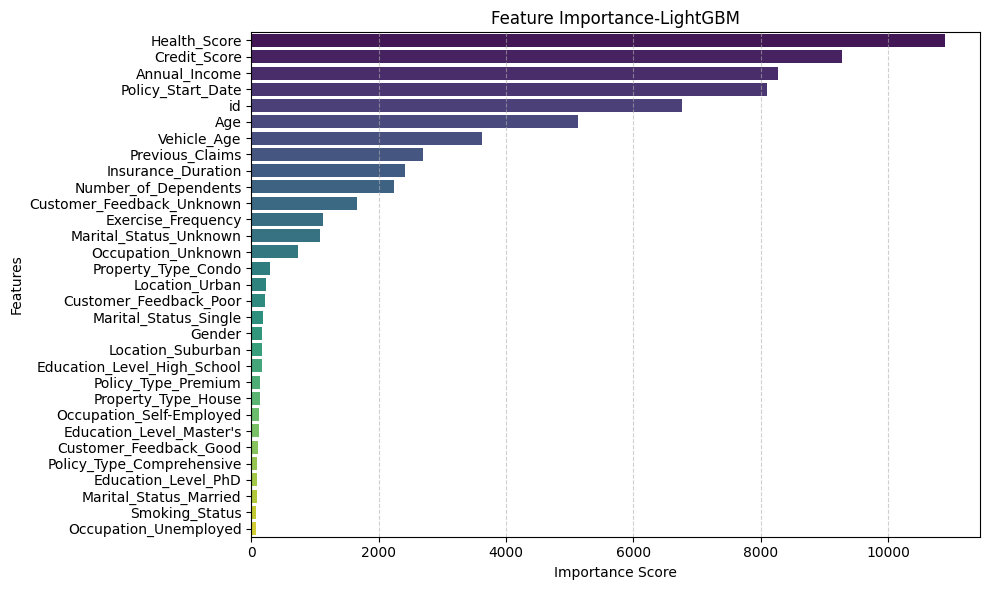

Top 10 Feature by Importance:



,Feature,Importance
5,Health_Score,10902
8,Credit_Score,9275
3,Annual_Income,8271
10,Policy_Start_Date,8098
0,id,6765
1,Age,5139
7,Vehicle_Age,3621
6,Previous_Claims,2700
9,Insurance_Duration,2415
4,Number_of_Dependents,2234


In [ ]:
# 결과 시각화
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')

plt.title('Feature Importance-LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("Top 10 Feature by Importance:\n")
display(feature_importance.head(10))

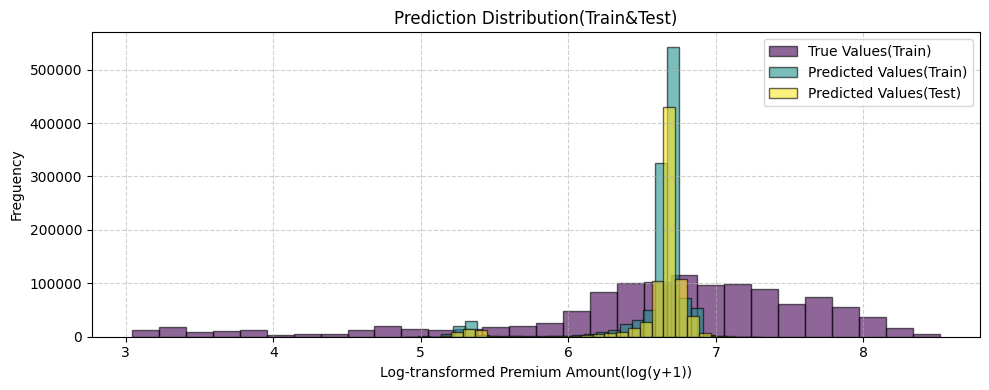

In [ ]:
# Test set 결과 비교
viridis_cmap = cm.get_cmap('viridis', 3)
plt.figure(figsize=(10, 4))

# True values(Train)
plt.hist(y_train_log, bins=30, color=viridis_cmap(0), alpha=0.6, edgecolor='black',
        label='True Values(Train)')

# predicted values(Train)
plt.hist(y_train_pred, bins=30, color=viridis_cmap(0.5), alpha=0.6, edgecolor='black',
        label='Predicted Values(Train)')

# predicted values(Test)
plt.hist(np.log1p(y_test_pred), bins=30, color=viridis_cmap(0.8), alpha=0.6, edgecolor='black',
        label='Predicted Values(Test)')

plt.title("Prediction Distribution(Train&Test)")
plt.xlabel('Log-transformed Premium Amount(log(y+1))')
plt.ylabel('Freguency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# **Submission**

In [ ]:
# Prepare submission
submission = pd.DataFrame({"id": test_data['id'], target_column: y_test_pred})

print(submission.head(10))

submission.to_csv("lgbm_optuna_submission.csv", index=False)
print("Submission file created successfully!")

        id  Premium Amount
0  1200000      764.252656
1  1200001      809.738031
2  1200002      814.114408
3  1200003      812.938001
4  1200004      762.954815
5  1200005      777.900639
6  1200006      966.463742
7  1200007      708.099041
8  1200008      207.124340
9  1200009      820.415808
Submission file created successfully!


In [ ]:
display(submission)

,id,Premium Amount
0,0,764.252656
1,1,809.738031
2,2,814.114408
3,3,812.938001
4,4,762.954815
...,...,...
799995,799995,980.212693
799996,799996,491.116625
799997,799997,826.076367
799998,799998,817.999920


-----------------------


In [ ]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 모델 정의
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
}

# 모델 학습 및 평가
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)

    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")